# Оглавление

- [Введение](#1)
- [Метод K-средних](#2)
- [Сравнений средних](#3)
- [Таблица сопряжённости](#4)
- [Метод главных компонент](#5)
- [Линейная регрессия](#6)
- [Характеристика аккуратности, точности, полноты](#7)
- [Заключение](#8)

<a id='1'></a>

# Введение

Согласно прогнозам экспертов, общий объём информации в мире достигнет 163 зеттабайт (это 163*10^23 байт!). И, конечно, возникает естественное желание проанализировать данные с целью выявления нетривиальных зависимостей.
В последние годы популярность криптовалюты растёт экспоненциально, особенно после резкого взлёта курса биткоина в конце прошлого года. Криптовалюта отличается от признанных мировых валют тем, что ни один банк, ни один государственный орган не сможет заблокировать, отменить или оспорить транзакцию (разумеется, не имея приватного ключа). Биткоин очевидно выделяется среди остальных: это первая криптовалюта, её рыночная капитализация приблизительно равна 7,42 триллиона рублей! Один биткоин сейчас стоит около полумиллиона, а в конце прошлого года курс достигал 1,3 миллиона рублей. Такие цифры не могут не привлекать предприимчивых студентов с факультета компьютерных наук, поэтому наша команда решила изучить колебания курса биткоина по разным параметрам за последний год. Возможно, нам удастся выявить интересные зависимости в данных, например, известно, что объём торгов напрямую влияет на курс.


Для начала загрузим все нужные для работы библиотеки и исследуемый датасет. Ссылка на скачивание датасета: [here](https://github.com/Bizzzarre/Bitcoin/blob/master/BITFINEX-BTCEUR.csv)

In [1]:
# Для построения графиков
from matplotlib import pyplot as plt
import seaborn as sns
# Для работы с численныими данными
import numpy as np
# Для работы с таблицами данных
import pandas as pd
# Для предобработки данных
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
# Используемые методы и алгоритмы
from sklearn.cluster import KMeans
from sklearn.linear_model import ElasticNet, LinearRegression, RidgeCV, Ridge, Lasso, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, GridSearchCV
# Для исследования ошибок и отклонений
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, mean_absolute_error

In [2]:
df = pd.read_csv('BITFINEX-BTCEUR.csv')

Рассмотрим его структуру:

In [3]:
df.head(10)

,Date,High,Low,Mid,Last,Bid,Ask,Volume
0,2018-09-24,5725.000000,5590.700000,5621.30,5621.251288,5621.2,5621.4,1906.769859
1,2018-09-23,5765.500000,5660.500000,5716.45,5717.479110,5716.4,5716.5,661.228552
2,2018-09-22,5811.700000,5524.626745,5703.60,5701.700000,5703.5,5703.7,877.826894
3,2018-09-21,5779.800000,5500.700000,5724.70,5724.600000,5724.6,5724.8,1842.455638
4,2018-09-20,5590.000011,5383.100000,5511.90,5511.900000,5511.8,5512.0,1030.104288
5,2018-09-19,5607.100001,5225.138005,5467.80,5467.800000,5467.7,5467.9,1952.956698
6,2018-09-18,5465.000000,5334.400000,5439.95,5439.905417,5439.9,5440.0,1160.235075
7,2018-09-17,5627.800020,5308.800000,5357.70,5360.000000,5357.6,5357.8,1990.087017
8,2018-09-16,5609.800000,5480.200000,5586.75,5586.800000,5586.7,5586.8,406.120140
9,2018-09-15,5647.599979,5556.800000,5608.40,5608.400000,5608.3,5608.5,293.474948


- Дата

Единицей времени в данном датафрейме являются сутки. Поскольку нам интересна долгосрочные изменения биткоина, ежечасные данные нам не подходят.

- Максимальная цена за сутки

- Минимальная цена за сутки

- Средняя цена за сутки

- Последняя зафиксированная цена за сутки

Поскольку курс криптовалюты нестабилен в течение суток, можно выделить несколько математических параметров, удобных для анализа, а именно min(), max() и mean() от ежесекундно фиксируемых данных о курсе.

- Средняя цена спроса (продажи) за сутки

- Средняя цена предложения (покупки)

- Объём торгов за текущий день


In [4]:
df.dtypes

Date       object
High      float64
Low       float64
Mid       float64
Last      float64
Bid       float64
Ask       float64
Volume    float64
dtype: object

Все признаки, кроме даты, являются количественными, что удобно для исследования и не требует вольной интерпретации

<a id='2'></a>

# Метод K-средних

Кластеризация - это разделение  данных на несколько групп по заданным параметрам "схожести". Для разделения данных на классы рассмотрим алгоритм _KMeans_ - наиболее простой, но вместе с тем неточный алгоритм кластеризации. Алгоритм разбивает данные на заранее известное количество классов $K$, стремясь минимизировать среднеквадратичное отклонение на точках каждого кластера.

In [5]:
data = df.copy()

Препроцессинг - не маловажная часть работы с данными. Во-первых, их необходимо масштабировать, для чего подойдёт StandardScaler. Во-вторых, с помощью `OneHotEncoding` переведём порядковый признак `Date` в количественный.

In [6]:
x = data[['Date','Bid', 'Ask', 'Last']].copy()
x = pd.get_dummies(x, columns=['Date'])
scaler = StandardScaler()
scaler.fit(x)
x_new = scaler.transform(x)

Рассмотрим разбиение на 5 кластеров. Дефолтное количество инициализаций равно 10, алгоритм автоматически выбирает тот, который минимизирует критерий метода.

In [7]:
_5means = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10)
_5means.fit(x_new)
x_labels_5 = _5means.labels_
x_labels_5 = pd.DataFrame(x_labels_5)
data_all = data.join(x_labels_5)
result_5 = data_all.rename(columns={0: "Cluster"})
result_5
clusters_5 = result_5.groupby(by="Cluster").count()
clusters_5.Date

Cluster
0     68
1     20
2     93
3    100
4     23
Name: Date, dtype: int64

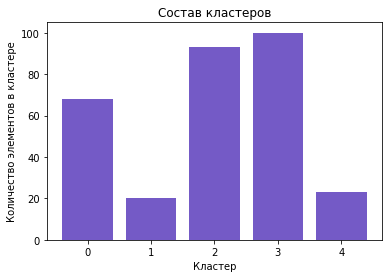

In [8]:
plt.bar(x=clusters_5.index, height=clusters_5.Date, color = '#3914AF', alpha = 0.7)
plt.xlabel("Кластер")
plt.ylabel("Количество элементов в кластере")
plt.title("Состав кластеров")
plt.show()

Как видно, размер кластеров далёк от среднего. Рассмотрим график, где по оси $x$ отложено время, по $y$ - среднее значение биткоина.

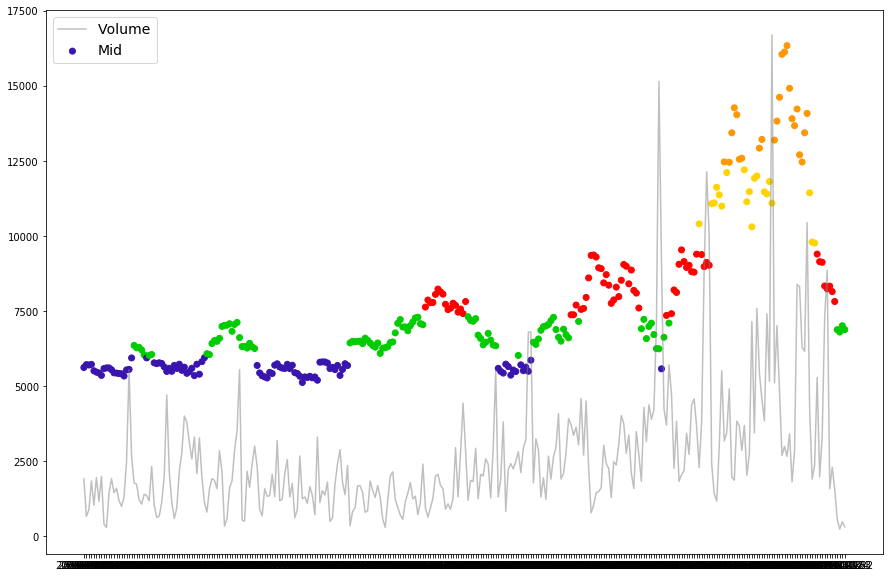

In [9]:
colors = []
for i in range(result_5.shape[0]):
    if (result_5.Cluster[i] == 0):
        colors.append('#FF0000')
    elif (result_5.Cluster[i] == 1):
        colors.append('#FFD300')
    elif (result_5.Cluster[i] == 2):
        colors.append('#3914AF')
    elif (result_5.Cluster[i] == 3):
        colors.append('#00CC00')
    else:
        colors.append('#FF9700')
        
x_1 = result_5.Date
y_1 = result_5.Mid
plt.figure(figsize = (15, 10))
plt.scatter(x_1, y_1, color=colors)
plt.plot(result_5.Volume, color = 'grey', alpha = 0.5)
plt.legend(loc = "upper left", fontsize=14)
plt.show()

Как видно, алгоритм разделил строго на ценовые сегменты, поскольку все параметры, связанные с курсом биткоина, очевидно, скореллированы, однако _OneHotEncoding_ сгладил промежутки между переходами из одного кластера в другой. 

Если добавить в рассмотрение параметр _Volume_, то в моменты пика объёмов торгов точки разбросаны достаточно хаотично.

In [10]:
x = data[['Date','Bid', 'Ask', 'Volume']].copy()
x = pd.get_dummies(x, columns=['Date'])
scaler = StandardScaler()
scaler.fit(x)
x_new = scaler.transform(x)
means = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10)
means.fit(x_new)
x_labels = means.labels_
x_labels = pd.DataFrame(x_labels)
data_all = data.join(x_labels)
result = data_all.rename(columns={0: "Cluster"})
result
clusters = result.groupby(by="Cluster").count()
clusters.Date

Cluster
0    161
1     39
2     29
3     61
4     14
Name: Date, dtype: int64

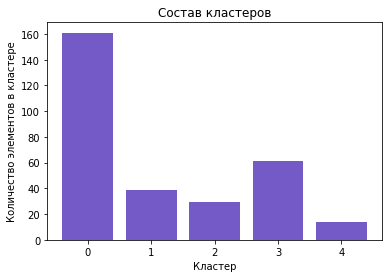

In [11]:
plt.bar(x=clusters.index, height=clusters.Date, color = '#3914AF', alpha = 0.7)
plt.xlabel("Кластер")
plt.ylabel("Количество элементов в кластере")
plt.title("Состав кластеров")
plt.show()

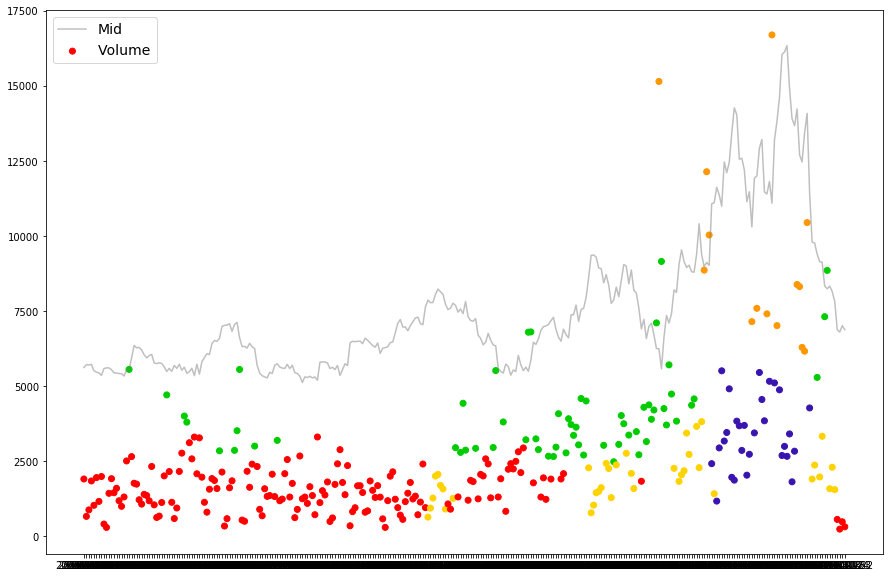

In [12]:
colors = []
for i in range(result.shape[0]):
    if (result.Cluster[i] == 0):
        colors.append('#FF0000')
    elif (result.Cluster[i] == 1):
        colors.append('#FFD300')
    elif (result.Cluster[i] == 2):
        colors.append('#3914AF')
    elif (result.Cluster[i] == 3):
        colors.append('#00CC00')
    else:
        colors.append('#FF9700')
        
x_1 = result.Date
y_1 = result.Volume
plt.figure(figsize = (15, 10))
plt.scatter(x_1, y_1, color=colors)
plt.plot(result.Mid, color = 'grey', alpha = 0.5)
plt.legend(loc = "upper left", fontsize=14)
plt.show()

Что ж, рассмотрим разбиение данных на 9 кластеров.

In [13]:
x = data[['Date','Bid', 'Ask', 'Last']].copy()
x = pd.get_dummies(x, columns=['Date'])
scaler = StandardScaler()
scaler.fit(x)
x_new = scaler.transform(x)
_9means = KMeans(n_clusters = 9, init = 'k-means++', n_init = 10)
_9means.fit(x_new)
x_labels_9 = _9means.labels_
x_labels_9 = pd.DataFrame(x_labels_9)
data_all = data.join(x_labels_9)
result_9 = data_all.rename(columns={0: "Cluster"})
clusters_9 = result_9.groupby(by="Cluster").count()

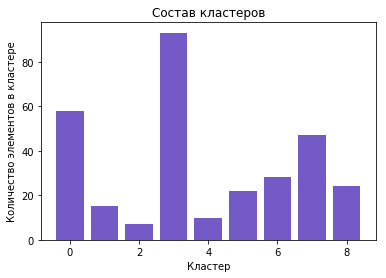

In [14]:
plt.bar(x=clusters_9.index, height=clusters_9.Date, color = '#3914AF', alpha = 0.7)
plt.xlabel("Кластер")
plt.ylabel("Количество элементов в кластере")
plt.title("Состав кластеров")
plt.show()

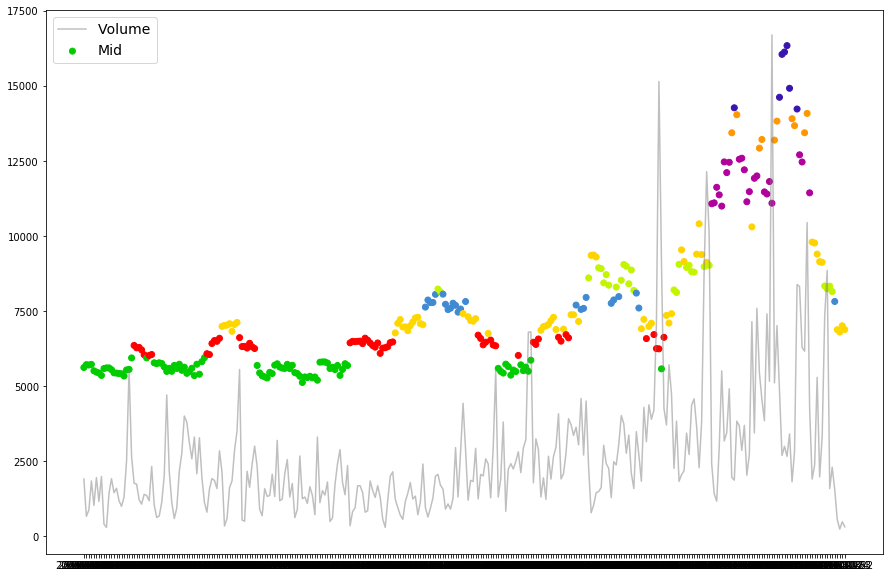

In [15]:
colors = []
for i in range(result.shape[0]):
    if (result_9.Cluster[i] == 0):
        colors.append('#FF0000')
    elif (result_9.Cluster[i] == 1):
        colors.append('#FFD300')
    elif (result_9.Cluster[i] == 2):
        colors.append('#3914AF')
    elif (result_9.Cluster[i] == 3):
        colors.append('#00CC00')
    elif (result_9.Cluster[i] == 4):
        colors.append('#FF9700')
    elif (result_9.Cluster[i] == 5):
        colors.append('#B1009B')
    elif (result_9.Cluster[i] == 6):
        colors.append('#C3F500')
    elif (result_9.Cluster[i] == 7):
        colors.append('gold')
    elif (result_9.Cluster[i] == 8):
        colors.append('#408AD2')
x_1 = result_9.Date
y_1 = result_9.Mid
plt.figure(figsize = (15, 10))
plt.scatter(x_1, y_1, color=colors)
plt.plot(result_9.Volume, color = 'grey', alpha = 0.5)
plt.legend(loc = "upper left", fontsize=14)
plt.show()

Разбиение на 9 кластеров по смыслу не даёт никакой более точной детализации, поскольку в случае с нашим датасетом данные разбиваются на ценовые сегменты. Из за большого скачка биткоина в декабре 2017 года этот пик делится на 4 более мелких, что не очень показательно для долгосрочного изменения курса биткоина. Следовательно, для наших данных более подходит разбиение на 5 кластеров.

Алгоритм имеет несколько недостатков:
- Необходимо заранее знать количество кластеров. Следовательно, чтобы разбиение было наиболее информативным, необходимо либо перебирать все $K$, либо иметь некоторые знания о том, на какие кластеры должны разбиться данные. В нашем случае алгоритм `5-means` оказался более информативным, однако мы сравнили лишь 2 разных $K$.
- Алгоритм очень чувствителен к изначальному выбору центров. Для решения этой проблемы может помочь неоднократный запуск алгоритма и аккуратно подобранные данные, к чему мы и прибегнули.
- Не справляется с задачей, когда объект принадлежит к разным кластерам в равной степени или не принадлежит ни одному. В предложенном датасете есть ярковыраженный пик, который делится на 2-4 кластера. По сути все эти кластеры описывают один короткий пик, вследствие чего размеры кластеров варьируются от 10 до более, чем 100 единиц. 

<a id='3'></a>

# Сравнение средних

### Сравнение средних значений средней цены предложения в двух самых больших кластерах

Возьмём самое первое разбиение (на 5 кластеров без учёта объёма торгов), поскольку в нём прослеживалась явное разделение на ценовые сегменты.

In [16]:
data = result_5

Рассмотрим два самых объёмных кластера для сравнения средних.

In [17]:
data['Cluster'].value_counts()

3    100
2     93
0     68
4     23
1     20
Name: Cluster, dtype: int64

In [18]:
k1 = data['Cluster'].value_counts().index[0]
k2 = data['Cluster'].value_counts().index[1]
print("First claster is", k1)
print("Second cluster is", k2)

First claster is 3
Second cluster is 2


Выделим 2 массива данных, соответствующих выбранным кластерам.

In [19]:
data_1 = np.array(data[data.Cluster == k1].Ask)
data_2 = np.array(data[data.Cluster == k2].Ask)

Фактические средние в данных равны:

In [20]:
print("Среднее значение цены предложения в 1 кластере равно ", round(np.mean(data_1),2), '$', sep='')
print("Среднее значение цены предложения во 2 кластере равно ", round(np.mean(data_2),2), '$', sep='')

Среднее значение цены предложения в 1 кластере равно 6668.16$
Среднее значение цены предложения во 2 кластере равно 5564.2$


Теперь оценим средние с помощью бутстрапа. Сгенерируем 50 выборок с возвращением размера `data_1.shape[0]` из значений первого кластера и 50 выборок с возвращением размера `data_2.shape[0]` из значений второго кластера и посчитаем средние средних в массивах `means_1` и `means_2`.

In [21]:
N = 50
means_1 = []
means_2 = []
for i in range(N):
    sample_1 = np.random.randint(low=0, high=data_1.shape[0], size=data_1.shape[0])
    m_1 = np.mean(data_1[sample_1])
    means_1.append(m_1)
    sample_2 = np.random.randint(low=0, high=data_2.shape[0], size=data_2.shape[0])
    m_2 = np.mean(data_2[sample_2])
    means_2.append(m_2)
mean_1 = np.mean(means_1)
mean_2 = np.mean(means_2)
print("Среднее значение цены предложения в 1 кластере равно ", round(mean_1, 2), '$', sep='')
print("Среднее значение цены предложения во 2 кластере равно ", round(mean_2, 2), '$', sep='')

Среднее значение цены предложения в 1 кластере равно 6673.57$
Среднее значение цены предложения во 2 кластере равно 5561.42$


Text(0.5,1,'Распределение средних во 2 кластере')

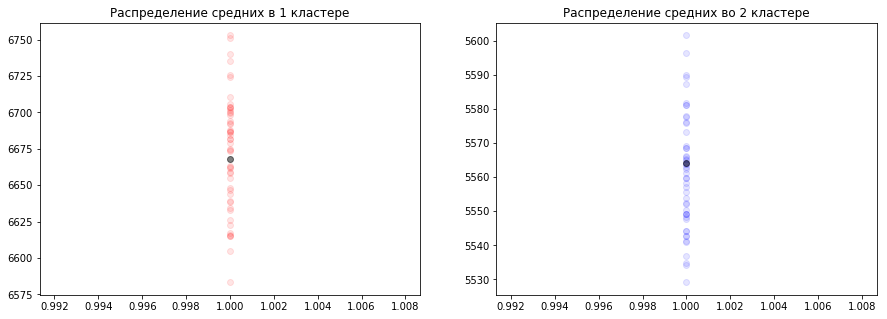

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
ax1.scatter([np.tile(1, N)], [means_1], color = 'r', alpha = 0.1)
ax2.scatter([np.tile(1, N)], [means_2], color = 'b', alpha = 0.1)
ax1.scatter(1, np.mean(data_1), color = 'k', alpha = 0.5)
ax2.scatter(1, np.mean(data_2), color = 'k', alpha = 0.5)
ax1.set_title("Распределение средних в 1 кластере")
ax2.set_title("Распределение средних во 2 кластере")

На общем графике распределение средних по бутстрапу не так показательно, но для сравнения двух средних построим:

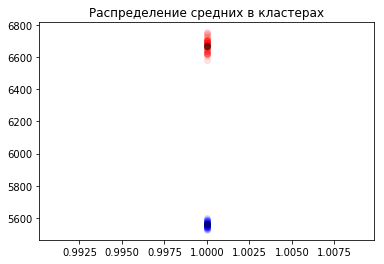

In [23]:
plt.scatter([np.tile(1, N)], [means_1], color = 'r', alpha = 0.1) # 1
plt.scatter([np.tile(1, N)], [means_2], color = 'b', alpha = 0.1) # 2
plt.scatter(1, np.mean(data_1), color = 'k', alpha = 0.5)
plt.scatter(1, np.mean(data_2), color = 'k', alpha = 0.5)
plt.title("Распределение средних в кластерах")
plt.show()

В 1 случае значения средних, полученные бутстрапом, концентрируются вокруг реального среднего. Для второго кластера значения имеют 2 выраженных центра и, если взять их среднее, то получится реальное среднее.

### Поиск 95% доверительного интервала для среднего значения объёма

Найдём доверительный интервал для среднего значения объёма. Для этого выберем 100 выборок из `df['Volume']`

In [24]:
data = np.array(df['Volume'].copy())
N = 100
means = []
for i in range(N):
    sample = np.random.randint(low=0, high=data.shape[0], size=data.shape[0])
    means.append(np.mean(data[sample]))
means = np.array(means)
mean_volume = np.mean(means)
print("Среднее значение равно:", mean_volume)
std = np.std(means)
#С опорой
print("Границы доверительного интервала, рассчитанные с опорой:")
print('left=', mean_volume - 1.96*std)
print('right=', mean_volume + 1.96*std)
#Без опоры
print("Границы доверительного интервала, рассчитанные без опоры:")
interval = means[(means > np.percentile(a=means, q=2.5)) & (means < np.percentile(a=means, q=97.5))]
print('left=', min(interval))
print('right=', max(interval))
real_mean_volume = np.mean(data)
print("Реальное среднее значение равно ", real_mean_volume)

Среднее значение равно: 2629.2202238562254
Границы доверительного интервала, рассчитанные с опорой:
left= 2384.0042950498614
right= 2874.4361526625894
Границы доверительного интервала, рассчитанные без опоры:
left= 2401.0197988860195
right= 2870.0971881760524
Реальное среднее значение равно  2635.5758857345063


Построим, что попало в доверительный интервал.

По расчётам границ с опорой в доверительный интервал попало 33 объектов.


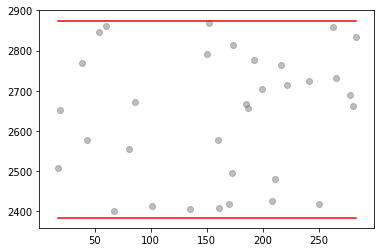

In [25]:
y_1 = mean_volume - 1.96*std
y_2 = mean_volume + 1.96*std
res = df[(df.Volume > y_1) & (df.Volume < y_2)].Volume
x = res.shape[0]
print("По расчётам границ с опорой в доверительный интервал попало", res.shape[0], "объектов.")
plt.plot(res.index, np.tile(y_1, x), color = "red")
plt.plot(res.index, np.tile(y_2, x), color = "red")
plt.scatter(res.index, res, color = 'grey', alpha = 0.5)
plt.show()

По расчётам границ без опоры в доверительный интервал попало 33 объектов.


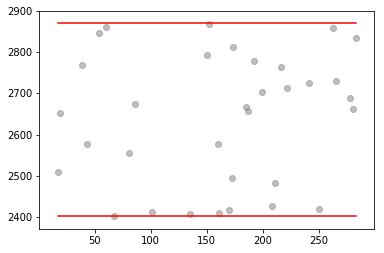

In [26]:
y_1 = min(interval)
y_2 = max(interval)
res = df[(df.Volume > y_1) & (df.Volume < y_2)].Volume
x = res.shape[0]
print("По расчётам границ без опоры в доверительный интервал попало", res.shape[0], "объектов.")
plt.plot(res.index, np.tile(y_1, x), color = "red")
plt.plot(res.index, np.tile(y_2, x), color = "red")
plt.scatter(res.index, res, color = 'grey', alpha = 0.5)
plt.show()

Нам повезло, что в доверительный интервал попали одинаковые элементы, поскольку полученные разными методами интервалы различаются.

### Сравнение средних объёмов торгов для всего датасета и для первого кластера

Общее среднее, полученное с помощью бутстрапа, уже известно:

In [27]:
print("Среднесуточный объём торгов равен", round(mean_volume, 2), "биткоинов")

Среднесуточный объём торгов равен 2629.22 биткоинов


Посчитаем `volume` на одном из кластеров

In [28]:
data_1 = np.array(data_1.copy())
N = 100
means_1 = []
for i in range(N):
    sample = np.random.randint(low=0, high=data_1.shape[0], size=data_1.shape[0])
    means_1.append(np.mean(data_1[sample]))
means_1 = np.array(means_1)
mean_volume_1 = np.mean(means_1)
print("Среднесуточный объём торгов равен", round(mean_volume_1, 2), "биткоинов")

Среднесуточный объём торгов равен 6666.82 биткоинов


Поскольку разбиение датасета напрямую коррелирует с курсом биткоина, то неудивительно, что средние могут так сильно отличаться.

<a id='4'></a>

# Таблицы сопряжённости

**Таблица сопряжённости** — средство представления совместного распределения двух переменных, предназначенное для исследования связи между ними. На основе наших данных построим две таблицы сопряженности, чтобы сравнить зависимость существующего признака 'Mid' от новосозданных признаков. Таблица относительных частот, индексов Кетле и коэффициентов хи-квадрат Пирсона также помогут нам в этом разобраться.

In [29]:
y = df.copy()

Чтобы работать с первым признаком, посмотрим, сколько у нас всего различных данных (alldata - строки в таблице) и какие максимальные и минимальные значения столбца 'Mid' - среднее значение. (Он нам нужен, потому что мы будем строить таблицу совместимости в зависимости от него).**

In [30]:
alldata = y.Date.nunique()
print(y['Mid'].max())
print(y['Mid'].min())

16345.5
5122.7


In [31]:
anyk = y.copy()
a = anyk['Mid']
tendency = []

#### Наш новый признак - предрасположенность среднего курса к росту, в зависимости от его значения. Для удобства сделаем четыре категории:
- Сильный рост
- Умеренный рост
- Умеренный спад
- Сильный спад

Этот признак поможет предсказывать и составит представление об изменении среднего курса в зависимости от его значения. Чтобы разделить наши данные по этим категориям, построим график изменения курса в зависимости от его среднего значения.

In [32]:
differ = []
for i in range(alldata - 1):
    differ.append(a[i] - a[i + 1])
differ.append(0)

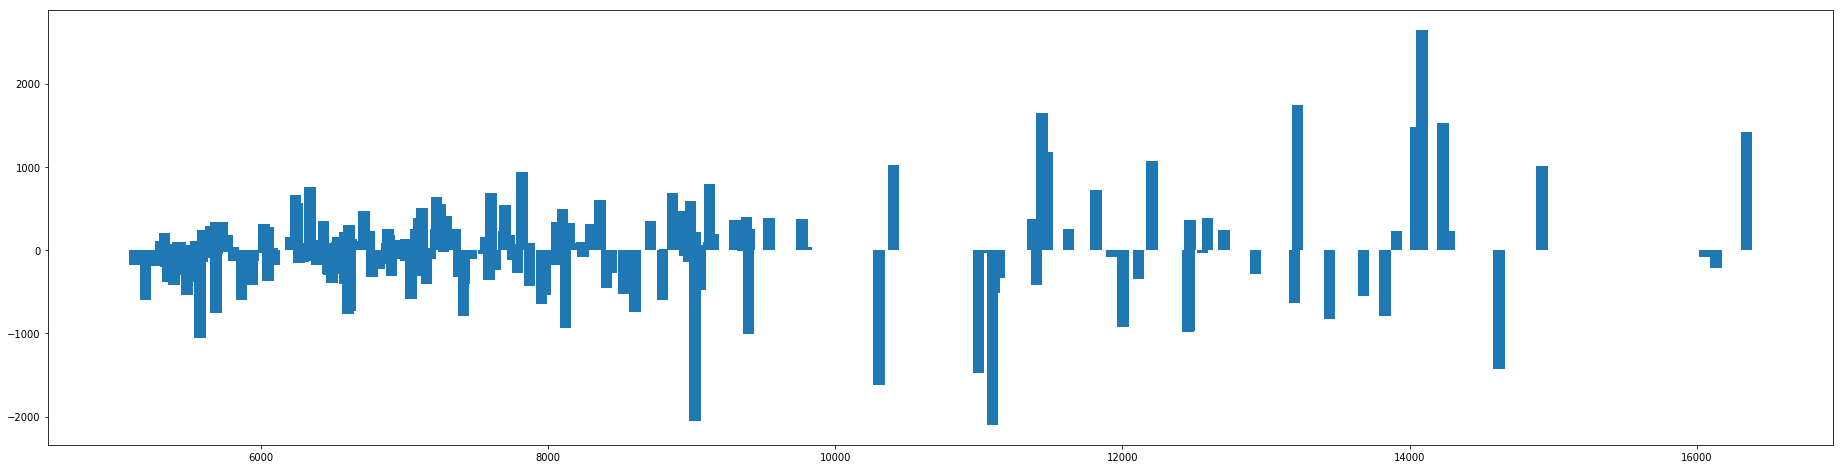

In [33]:
plt.subplots(figsize=(32, 8))
plt.bar(anyk.Mid, differ, align='center', width=80)
plt.show()

На данном графике видно, что умеренные отклонения - это примерно +- 400 пунктов. Все, что больше, можно назвать сильным изменением. Поэтому соствим признак, где присваиваем данным цифру от 1 до 4 в зависимости от их поведения:

- Сильный рост (4)
- Умеренный рост (3)
- Умеренный спад (2)
- Сильный спад (1)

По этим параметрам построим этот новый признак (Тенденция) и добавим его к нашим данным.

In [34]:
for i in range(alldata - 1):
    if (a[i] > a[i + 1] + 400):
        tendency.append(1)
    elif (a[i + 1] + 400 >= a[i] > a[i + 1]):
        tendency.append(2)
    elif (a[i + 1] - 400 < a[i] <= a[i + 1]):
        tendency.append(3)
    elif (a[i + 1] - 400 >= a[i]):
        tendency.append(4)
tendency1 = pd.DataFrame({'Tendency': tendency})
anyk['Tendency'] = tendency1
t = anyk['Tendency']

Теперь наша таблица с данными выглядит вот так:

In [35]:
anyk.head(10)

,Date,High,Low,Mid,Last,Bid,Ask,Volume,Tendency
0,2018-09-24,5725.000000,5590.700000,5621.30,5621.251288,5621.2,5621.4,1906.769859,3.0
1,2018-09-23,5765.500000,5660.500000,5716.45,5717.479110,5716.4,5716.5,661.228552,2.0
2,2018-09-22,5811.700000,5524.626745,5703.60,5701.700000,5703.5,5703.7,877.826894,3.0
3,2018-09-21,5779.800000,5500.700000,5724.70,5724.600000,5724.6,5724.8,1842.455638,2.0
4,2018-09-20,5590.000011,5383.100000,5511.90,5511.900000,5511.8,5512.0,1030.104288,2.0
5,2018-09-19,5607.100001,5225.138005,5467.80,5467.800000,5467.7,5467.9,1952.956698,2.0
6,2018-09-18,5465.000000,5334.400000,5439.95,5439.905417,5439.9,5440.0,1160.235075,2.0
7,2018-09-17,5627.800020,5308.800000,5357.70,5360.000000,5357.6,5357.8,1990.087017,3.0
8,2018-09-16,5609.800000,5480.200000,5586.75,5586.800000,5586.7,5586.8,406.120140,3.0
9,2018-09-15,5647.599979,5556.800000,5608.40,5608.400000,5608.3,5608.5,293.474948,2.0


In [36]:
anyk = anyk.sort_values('Mid')

 Теперь посмотрим,  на сколько категорий надо будет разделить наш количественный признак (среднее значение).

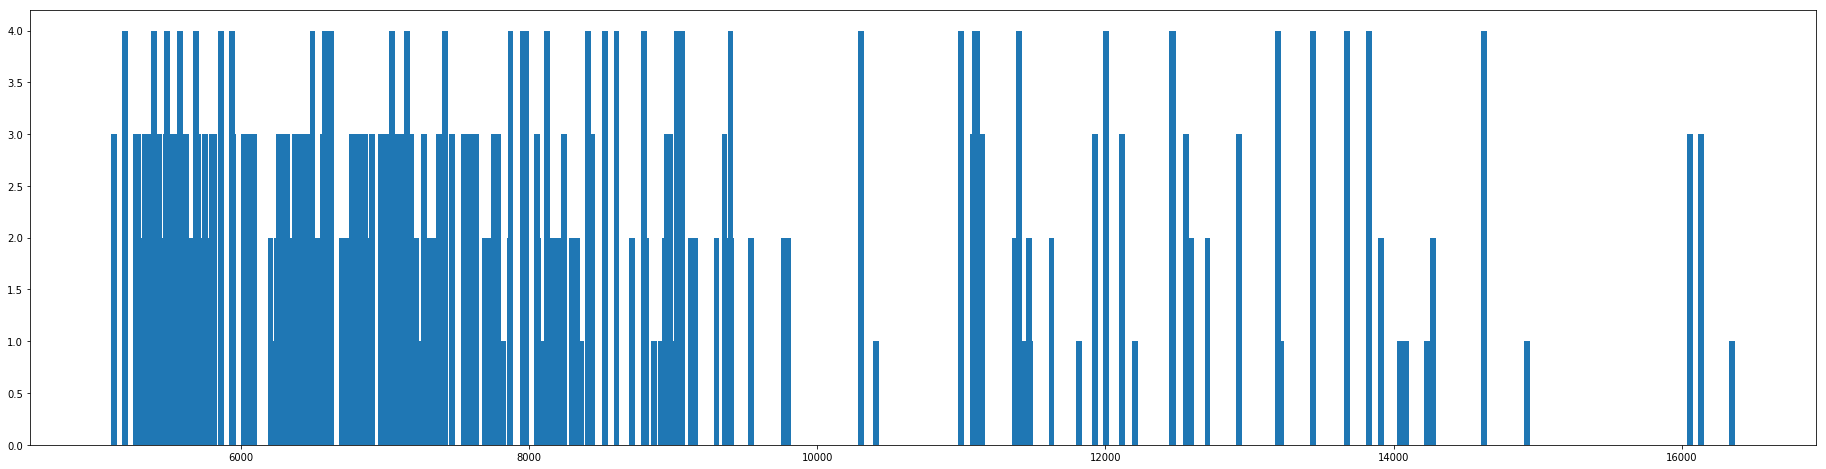

In [37]:
plt.subplots(1, 1, figsize=(32, 8))
plt.bar(anyk.Mid, anyk.Tendency, align='center', width=40)
plt.show()

 Как видно из графика, большинство данных фокусируются до курса 10000. Поэтому, опираясь на такое разделение, построим три границы, разделяя наши данные на четыре категории:

- 6000 и меньше (6000-)
- от 6000 до 8000 (6000+)
- от 80000 до 11000 (8000+)
- 11000 и больше (11000+)

Мы выбрали такие границы, поскольку в них заметны локальные минимумы (а также цифры сами по себе круглые и удобные). Поэтому продолжим работать с ними. Для этого построим таблицу смежности - посчитаем для каждого признака из этих категорий соответствующие значения из признака 'Tendency'.

In [38]:
hugeDown1 = anyk.loc[(a < 6000) & (t == 1)].Date.count()
hugeDown2 = anyk.loc[(6000 <= a) & (a < 8000) & (t == 1)].Date.count()
hugeDown3 = anyk.loc[(8000 <= a) & (a < 11000) & (t == 1)].Date.count()
hugeDown4 = anyk.loc[(a >= 11000) & (t == 1)].Date.count()

In [39]:
Down1 = anyk.loc[(a < 6000) & (t == 2)].Date.count()
Down2 = anyk.loc[(6000 <= a) & (a < 8000) & (t == 2)].Date.count()
Down3 = anyk.loc[(8000 <= a) & (a < 11000) & (t == 2)].Date.count()
Down4 = anyk.loc[(a >= 11000) & (t == 2)].Date.count()

In [40]:
Up1 = anyk.loc[(a < 6000) & (t == 3)].Date.count()
Up2 = anyk.loc[(6000 <= a) & (a < 8000) & (t == 3)].Date.count()
Up3 = anyk.loc[(8000 <= a) & (a < 11000) & (t == 3)].Date.count()
Up4 = anyk.loc[(a >= 11000) & (t == 3)].Date.count()

In [41]:
hugeUp1 = anyk.loc[(a < 6000) & (t == 4)].Date.count()
hugeUp2 = anyk.loc[(6000 <= a) & (a < 8000) & (t == 4)].Date.count()
hugeUp3 = anyk.loc[(8000 <= a) & (a < 11000) & (t == 4)].Date.count()
hugeUp4 = anyk.loc[(a >= 11000) & (t == 4)].Date.count()

In [42]:
sasSum = [hugeDown1 + hugeDown2 + hugeDown3 + hugeDown4,
            Down1 + Down2 + Down3 + Down4, Up1 + Up2 + Up3 + Up4,
            hugeUp1 + hugeUp2 + hugeUp3 + hugeUp4,
            hugeDown1 + hugeDown2 + hugeDown3 + hugeDown4 +
            Down1 + Down2 + Down3 + Down4 + Up1 + Up2 + Up3 + Up4 +
            hugeUp1 + hugeUp2 + hugeUp3 + hugeUp4]

In [43]:
df_ = pd.DataFrame({
    '6000-': [hugeDown1, Down1, Up1, hugeUp1, hugeDown1 + Down1 + Up1 + hugeUp1],
    '6000+': [hugeDown2, Down2, Up2, hugeUp2, hugeDown2 + Down2 + Up2 + hugeUp2],
    '8000+': [hugeDown3, Down3, Up3, hugeUp3, hugeDown3 + Down3 + Up3 + hugeUp3],
    '11000+': [hugeDown4, Down4, Up4, hugeUp4, hugeDown4 + Down4 + Up4 + hugeUp4],
    'Sum': sasSum
}, index = ['Huge Down', 'Down', 'Up', 'Huge Up', 'Sum'])

In [44]:
cols = df_.columns.tolist()

In [45]:
cols = [ '6000-', '6000+', '8000+', '11000+', 'Sum']

In [46]:
df_ = df_[cols]

Получили такую таблицу смежности (признака 'Tendency' и признака 'Mid'). Посчитали сумму для каждого из них.

In [47]:
df_ #Таблица сопряженности

,6000-,6000+,8000+,11000+,Sum
Huge Down,0,12,8,10,30
Down,51,47,23,8,129
Up,35,55,6,8,104
Huge Up,7,11,10,12,40
Sum,93,125,47,38,303


In [48]:
chastot = ((df_ * 100)/303).round(2)

In [49]:
chastot #Таблица относительных частот в %

,6000-,6000+,8000+,11000+,Sum
Huge Down,0.00,3.96,2.64,3.30,9.90
Down,16.83,15.51,7.59,2.64,42.57
Up,11.55,18.15,1.98,2.64,34.32
Huge Up,2.31,3.63,3.30,3.96,13.20
Sum,30.69,41.25,15.51,12.54,100.00


In [50]:
ketle = chastot / 100

In [51]:
for i in range(4):
    ketle['6000-'][i] /= ketle['Sum'][i]
    ketle['6000+'][i] /= ketle['Sum'][i]
    ketle['8000+'][i] /= ketle['Sum'][i]
    ketle['11000+'][i] /= ketle['Sum'][i]

In [52]:
ketle['6000-'] /= ketle['6000-'][4]
ketle['6000+'] /= ketle['6000+'][4]
ketle['8000+'] /= ketle['8000+'][4]
ketle['11000+'] /= ketle['11000+'][4]

In [53]:
ketle -= 1

In [54]:
ketle = ketle.drop('Sum', 1)
ketle = ketle.drop(ketle.index[len(ketle) - 1])

In [55]:
ketle = (ketle * 100).round(2) #Таблица индексов Кетле %

In [56]:
ketle_point = ketle.copy()

In [57]:
ketle_point['6000-']['Down'] = '[' + str(ketle_point['6000-']['Down']) + ']'
ketle_point['6000+']['Up'] = '[' + str(ketle_point['6000+']['Up']) + ']'
ketle_point['8000+']['Huge Down'] = '[' + str(ketle_point['8000+']['Huge Down']) + ']'
ketle_point['8000+']['Huge Up'] = '[' + str(ketle_point['8000+']['Huge Up']) + ']'
ketle_point['11000+']['Huge Down'] = '[' + str(ketle_point['11000+']['Huge Down']) + ']'
ketle_point['11000+']['Huge Up'] = '[' + str(ketle_point['11000+']['Huge Up']) + ']'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-pa

В этой таблице индексов Кетле выделены большие значения (>28). Эти ячейки говорят о высокой связи условной и безусловной вероятности строки. А это значит, что в случае курса 11000+ вероятности резкого спада или резкого подъема достаточно высоки. В то время как вероятность незначительного изменения очень мала. Это говорит нам о больших рисках. Покупая биткоин по такому курсу, можно как и сильно выиграть от этого, так и сильно проиграть. Среднего не дано.

С другой стороны, если курс равен 6000+, то в нем велика вероятность подъема (хоть и не большого) по сравнению с другими изменениями. В этом случае очень правильно покупать биткоин, так как в следующие дни (после вероятного подъема) его будет выгоднее продавать.

In [58]:
ketle_point

,6000-,6000+,8000+,11000+
Huge Down,-100,-3.03,[71.93],[165.82]
Down,[28.82],-11.67,14.95,-50.55
Up,9.66,[28.21],-62.8,-38.66
Huge Up,-42.98,-33.33,[61.19],[139.23]


In [59]:
chastoty = chastot.drop('Sum', 1)
chastoty = chastoty.drop(chastot.index[len(chastot) - 1])

In [60]:
chiSq = (chastoty / 100) * ketle

In [61]:
chiSquare = (sum(chiSq['6000-']) + sum(chiSq['6000+']) + sum(chiSq['8000+']) + sum(chiSq['11000+']))
print('Коэффициент Хи-квадрат Пирсона: ', chiSquare)

# коэффициет хи-квадрат Пирсона

Коэффициент Хи-квадрат Пирсона:  19.39344


In [62]:
chiSq = (chiSq * 100).round(2) # хи-квадрат для пары %

In [63]:
chi = chiSq.copy()

In [64]:
chi['6000-']['Down'] = '[' + str(chi['6000-']['Down']) + ']'
chi['6000+']['Up'] = '[' + str(chi['6000+']['Up']) + ']'
chi['11000+']['Huge Down'] = '[' + str(chi['11000+']['Huge Down']) + ']'
chi['11000+']['Huge Up'] = '[' + str(chi['11000+']['Huge Up']) + ']'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-pa

В этой тиблице хи-квадратов выделены наибольшие значения (>4). Значит, между этими признаками есть статистическая взаимосвязь.

In [65]:
chi

,6000-,6000+,8000+,11000+
Huge Down,-0,-12,189.90,[547.21]
Down,[485.04],-181,113.47,-133.45
Up,111.57,[512.01],-124.34,-102.06
Huge Up,-99.28,-120.99,201.93,[551.35]


#### Проанализировали признак. Теперь рассмотрим еще один.

Создадим новый признак - разница между наибольшим и наименьшим курсом в течение дня.  И сравним его с последним средним значением курса (мы хотим узнать, лучше ли этот признак влияет на наш, чем предыдущий).

Для построения таблицы сопряженности и индексов Кетле проведем такую же работу, как и при построении первого признака.

In [66]:
difference = anyk.High - anyk.Low
anyk['Difference'] = difference.round(2) #округлим до 2х знаков после запятой

In [67]:
anyk = anyk.sort_values('Mid')

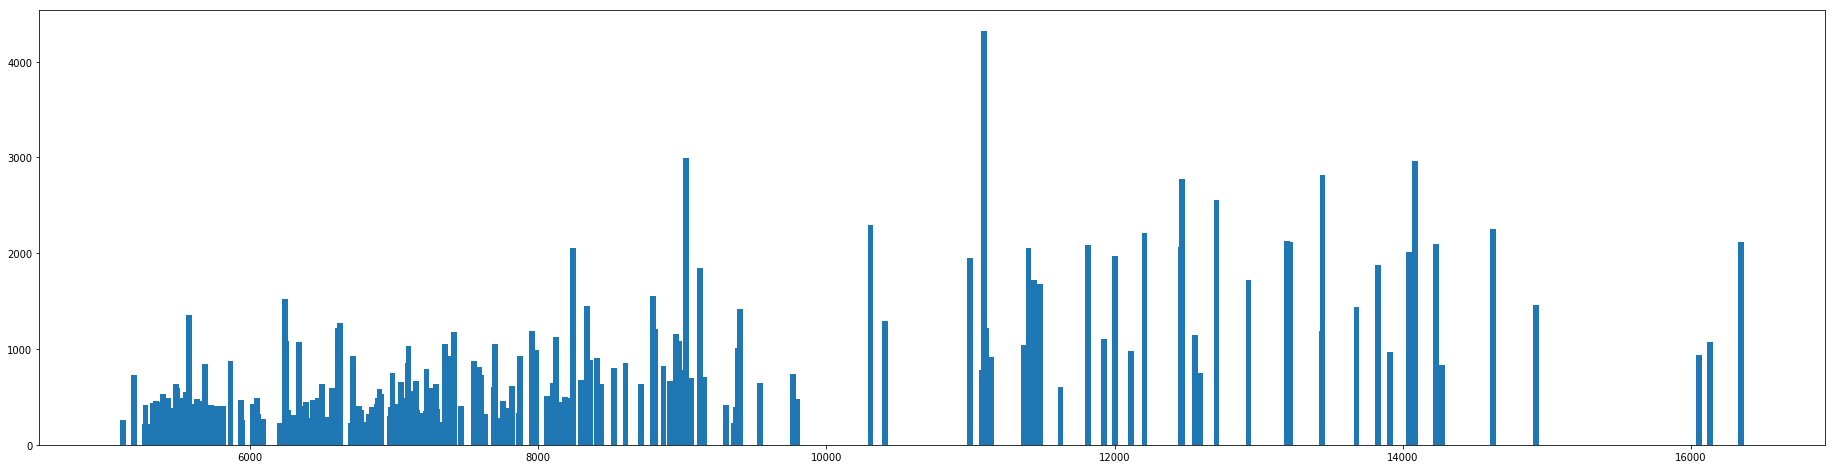

In [68]:
plt.subplots(1, 1, figsize=(32, 8))
plt.bar(anyk.Mid, anyk.Difference, align='center', width=40)
plt.show()

Заметим, что здесь также можно разделить данные (Last) на 4 части. А именно:

- 6000 и меньше (6000-)
- от 6000 до 8000 (6000+)
- от 8000 до 11000 (8000+)
- 11000 и больше (11000+)

Именно в этих точках расположены локальные минимумы, а также в этих интервалах количество данных примерно схожее, так что даст более четкий анализ.

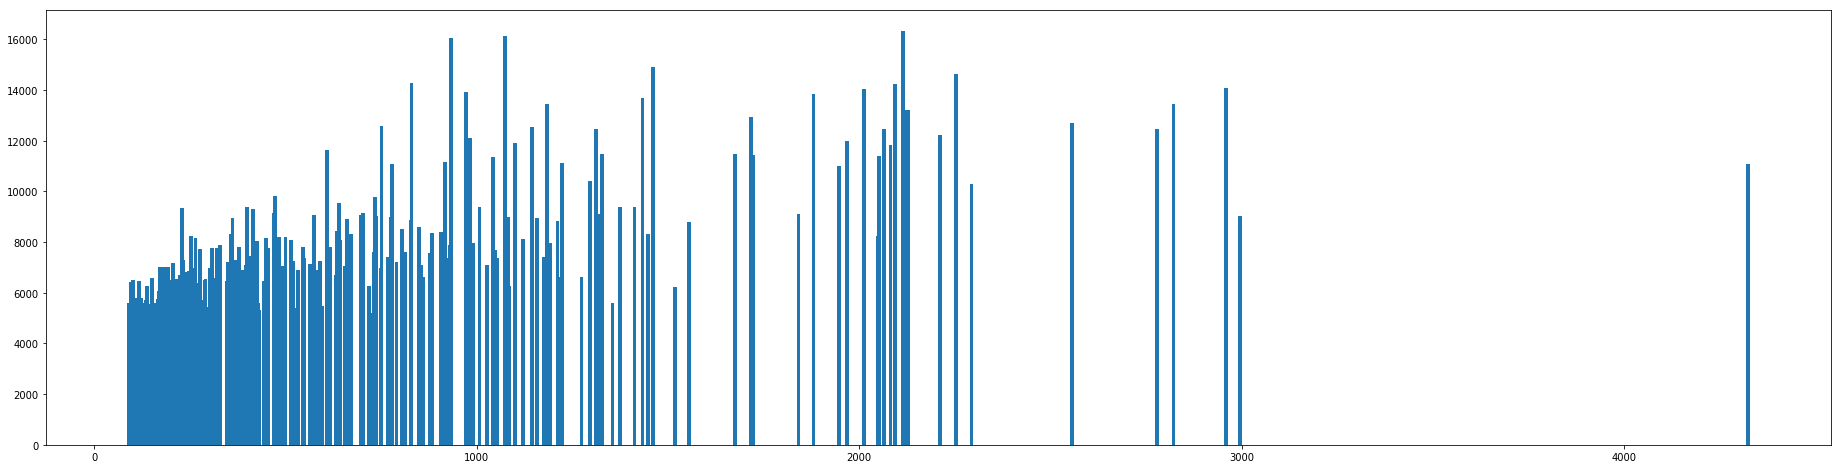

In [69]:
plt.subplots(1, 1, figsize=(32, 8))
plt.bar(anyk.Difference, anyk.Mid, align='center', width=10)
plt.show()

Теперь разделим наш 'Difference' на части. Для этого мы построили график зависимости наоборот. Можно заметить, что большинство значений локализовано в небольших значениях. Поэтому разделим на такие части:

- 350 и меньше (видно, что примерно в этом месте локализован минимум) (Almost same)
- от 350 до 650 (очередной локальный минимум) (Small difference)
- от 650 до 1200 (примерно там еще один минимум) (Big difference)
- 1200 и больше (Huge difference)

Можно было бы добавить и еще одно разбиение, так как в последнем интервале достаточно большой разрыв, однако мы не будем так делать, чтобы оставить примерно одинаковое количество данных в каждой категории. Тогда анализ будет более точным.

Теперь, когда оба признака разбиты на номинальные категории, можно составлять таблицу сопряженности.

In [70]:
l = anyk['Mid']
d = anyk['Difference']

In [71]:
AlmostSame1 = anyk.loc[(l < 6000) & (d < 350)].Date.count()
AlmostSame2 = anyk.loc[(l >= 6000) & (l < 8000) & (d < 350)].Date.count()
AlmostSame3 = anyk.loc[(l >= 8000) & (l < 11000) & (d < 350)].Date.count()
AlmostSame4 = anyk.loc[(l >= 11000) & (d < 350)].Date.count()

In [72]:
SmallDiff1 = anyk.loc[(l < 6000) & (d >= 350) & (d < 650)].Date.count()
SmallDiff2 = anyk.loc[(l >= 6000) & (l < 8000) & (d >= 350) & (d < 650)].Date.count()
SmallDiff3 = anyk.loc[(l >= 8000) & (l < 11000) & (d >= 350) & (d < 650)].Date.count()
SmallDiff4 = anyk.loc[(l >= 11000) & (d >= 350) & (d < 650)].Date.count()

In [73]:
BigDiff1 = anyk.loc[(l < 6000) & (d >= 650) & (d < 1200)].Date.count()
BigDiff2 = anyk.loc[(l >= 6000) & (l < 8000) & (d >= 650) & (d < 1200)].Date.count()
BigDiff3 = anyk.loc[(l >= 8000) & (l < 11000) & (d >= 650) & (d < 1200)].Date.count()
BigDiff4 = anyk.loc[(l >= 11000) & (d >= 650) & (d < 1200)].Date.count()

In [74]:
HugeDiff1 = anyk.loc[(l < 6000) & (d >= 1200)].Date.count()
HugeDiff2 = anyk.loc[(l >= 6000) & (l < 8000) & (d >= 1200)].Date.count()
HugeDiff3 = anyk.loc[(l >= 8000) & (l < 11000) & (d >= 1200)].Date.count()
HugeDiff4 = anyk.loc[(l >= 11000) & (d >= 1200)].Date.count()

In [75]:
sasSum = [AlmostSame1 + AlmostSame2 + AlmostSame3 + AlmostSame4,
          SmallDiff1 + SmallDiff2 + SmallDiff3 + SmallDiff4,
          BigDiff1 + BigDiff2 + BigDiff3 + BigDiff4,
          HugeDiff1 + HugeDiff2 + HugeDiff3 + HugeDiff4,
          AlmostSame1 + AlmostSame2 + AlmostSame3 + AlmostSame4 +
          SmallDiff1 + SmallDiff2 + SmallDiff3 + SmallDiff4 +
          BigDiff1 + BigDiff2 + BigDiff3 + BigDiff4 +
          HugeDiff1 + HugeDiff2 + HugeDiff3 + HugeDiff4]

In [76]:
df1 = pd.DataFrame({
    '6000-': [AlmostSame1, SmallDiff1, BigDiff1, HugeDiff1, AlmostSame1 + SmallDiff1 + BigDiff1 + HugeDiff1],
    '6000+': [AlmostSame2, SmallDiff2, BigDiff2, HugeDiff2, AlmostSame2 + SmallDiff2 + BigDiff2 + HugeDiff2],
    '8000+': [AlmostSame3, SmallDiff3, BigDiff3, HugeDiff3, AlmostSame3 + SmallDiff3 + BigDiff3 + HugeDiff3],
    '11000+': [AlmostSame4, SmallDiff4, BigDiff4, HugeDiff4, AlmostSame4 + SmallDiff4 + BigDiff4 + HugeDiff4],
    'Sum': sasSum
}, index = ['Almost same', 'Small Difference', 'Big Difference', 'Huge Difference', 'Sum'])

In [77]:
cols = [ '6000-', '6000+', '8000+', '11000+', 'Sum']
df1 = df1[cols]

#### Таблица смежности

In [78]:
df1

,6000-,6000+,8000+,11000+,Sum
Almost same,64,56,3,0,123
Small Difference,25,45,16,1,87
Big Difference,3,22,16,12,53
Huge Difference,1,3,12,25,41
Sum,93,126,47,38,304


In [79]:
chastot1 = ((df1 * 100)/304).round(2)

In [80]:
chastot1 #Табличка относительных частот в %

,6000-,6000+,8000+,11000+,Sum
Almost same,21.05,18.42,0.99,0.00,40.46
Small Difference,8.22,14.80,5.26,0.33,28.62
Big Difference,0.99,7.24,5.26,3.95,17.43
Huge Difference,0.33,0.99,3.95,8.22,13.49
Sum,30.59,41.45,15.46,12.50,100.00


In [81]:
ketle1 = chastot1 / 100

In [82]:
for i in range(4):
    ketle1['6000-'][i] /= ketle1['Sum'][i]
    ketle1['6000+'][i] /= ketle1['Sum'][i]
    ketle1['8000+'][i] /= ketle1['Sum'][i]
    ketle1['11000+'][i] /= ketle1['Sum'][i]

In [83]:
ketle1['6000-'] /= ketle1['6000-'][4]
ketle1['6000+'] /= ketle1['6000+'][4]
ketle1['8000+'] /= ketle1['8000+'][4]
ketle1['11000+'] /= ketle1['11000+'][4]

In [84]:
ketle1 -= 1
ketle1 = ketle1.drop('Sum', 1)
ketle1 = ketle1.drop(ketle1.index[len(ketle1) - 1])

In [85]:
ketle1 = (ketle1 * 100).round(2) #Таблица индексов Кетле в %

In [86]:
ketle_point1 = ketle1.copy()
ketle_point1['6000-']['Almost same'] = '[' + str(ketle_point1['6000-']['Almost same']) + ']'
ketle_point1['8000+']['Big Difference'] = '[' + str(ketle_point1['8000+']['Big Difference']) + ']'
ketle_point1['11000+']['Big Difference'] = '[' + str(ketle_point1['11000+']['Big Difference']) + ']'
ketle_point1['8000+']['Huge Difference'] = '[' + str(ketle_point1['8000+']['Huge Difference']) + ']'
ketle_point1['11000+']['Huge Difference'] = '[' + str(ketle_point1['11000+']['Huge Difference']) + ']'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.p

Здесь мы видим сильную зависимость там, где значения выделены. Предоставленные результаты не удивительны. Посмотрев на нашу таблицу индексов Кетле, можно сказать, что если курс был относительно малым (6000-), то и изменения в течение дня не сильно колебались, значения были практически одинаковыми на протяжении дня.

С другой стороны, в случае высокого курса (8000+ и 11000+) в данных преобладает большой разрыв между наименьшим и наибольшим значением за день. Видно, насколько нестабилен курс в этом случае.

In [87]:
ketle_point1

,6000-,6000+,8000+,11000+
Almost same,[70.08],9.83,-84.17,-100
Small Difference,-6.11,24.76,18.88,-90.78
Big Difference,-81.43,0.21,[95.2],[81.3]
Huge Difference,-92,-82.29,[89.4],[387.47]


In [88]:
chastoty1 = chastot1.drop('Sum', 1)
chastoty1 = chastoty1.drop(chastot1.index[len(chastot1) - 1])

In [89]:
chiSq1 = (chastoty1 / 100) * ketle1

In [90]:
chiSquare1 = (sum(chiSq1['6000-']) + sum(chiSq1['6000+']) + sum(chiSq1['8000+']) + sum(chiSq1['11000+']))
print('Kоэффициет хи-квадрат Пирсона: ', chiSquare1)

# коэффициет хи-квадрат Пирсона

Kоэффициет хи-квадрат Пирсона:  61.27597500000001


In [91]:
chiSq1 = (chiSq1 * 100).round(2) # хи-квадрат для пары %

In [92]:
chi1 = chiSq1.copy()

In [93]:
chi1['6000-']['Almost same'] = '[' + str(chi1['6000-']['Almost same']) + ']'
chi1['6000+']['Small Difference'] = '[' + str(chi1['6000+']['Small Difference']) + ']'
chi1['8000+']['Big Difference'] = '[' + str(chi1['8000+']['Big Difference']) + ']'
chi1['11000+']['Huge Difference'] = '[' + str(chi1['11000+']['Huge Difference']) + ']'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-pa

В данной таблице наиболее выраженная статистическая взаимосвязь между выделенными значениями (показатель > 350). Внмательно посмотрев на нее, можно сделать вывод, что чем больший у нас курс, тем больше колеболется значение курса в течение дня. 

In [94]:
chi1

,6000-,6000+,8000+,11000+
Almost same,[1475.18],181.07,-83.33,-0
Small Difference,-50.22,[366.45],99.31,-29.96
Big Difference,-80.62,1.52,[500.75],321.14
Huge Difference,-30.36,-81.47,353.13,[3185.0]


При построении таблиц для этих двух признаков мы получили хи-квадрат Пирсона =~ 61. В то время как для первого признака значение было =~ 19. Значит этот признак гораздо сильнее статистически связан, чем предыдущий. Это можно объяснить практически линейной зависимостью среднего значения от разницы между наибольшим и наименьшим значением в течение дня. Для первого признака нет такой явной зависимости, однако связь с ним тоже достаточно большая. 

Подытожив, можно сказать, что оба новых признака ('Tendency' и 'Difference') сильно связаны с изначально данным в таблице средним значением. Однако 'Difference' более точен.

<a id='5'></a>

# Метод главных компонент

Общая цель метода главных компонент - это сложными математическими операциями над матрицами уменьшить размерность наших данных и построить уменьшенную модель, отражающую некоторую связь параметров. Покажем это на примере некоторых параметров из наших данных.

In [95]:
f = df.copy()

Посмотрим на корреляцию наших признаков

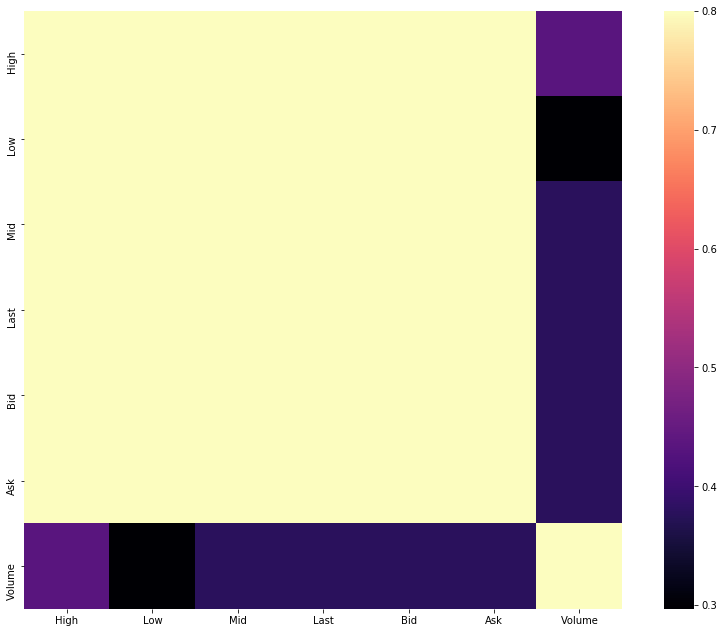

In [96]:
corr = f.corr()
plt.figure(figsize=(15, 11))
sns.heatmap(corr, vmax=.8, square=True, cmap='magma');

Оставим High, Low, Mid и Volume, потому что Volume "дальше" от остальных, а первые три все по-разному с ней коррелируют

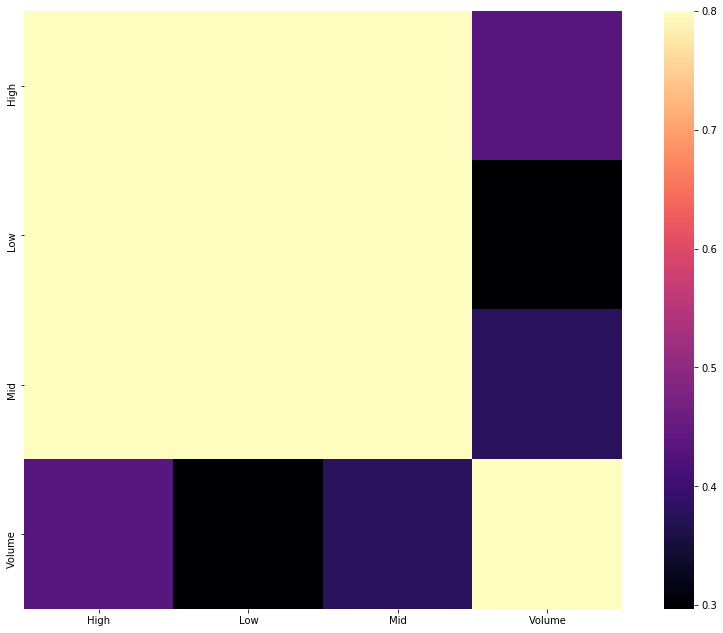

In [97]:
f.drop(['Last', 'Bid', 'Ask', 'Date'], 1, inplace=True)
corr = f.corr()
plt.figure(figsize=(15, 11))
sns.heatmap(corr, vmax=.8, square=True, cmap='magma');

Построим графики для четырёх признаков

До нормализации:


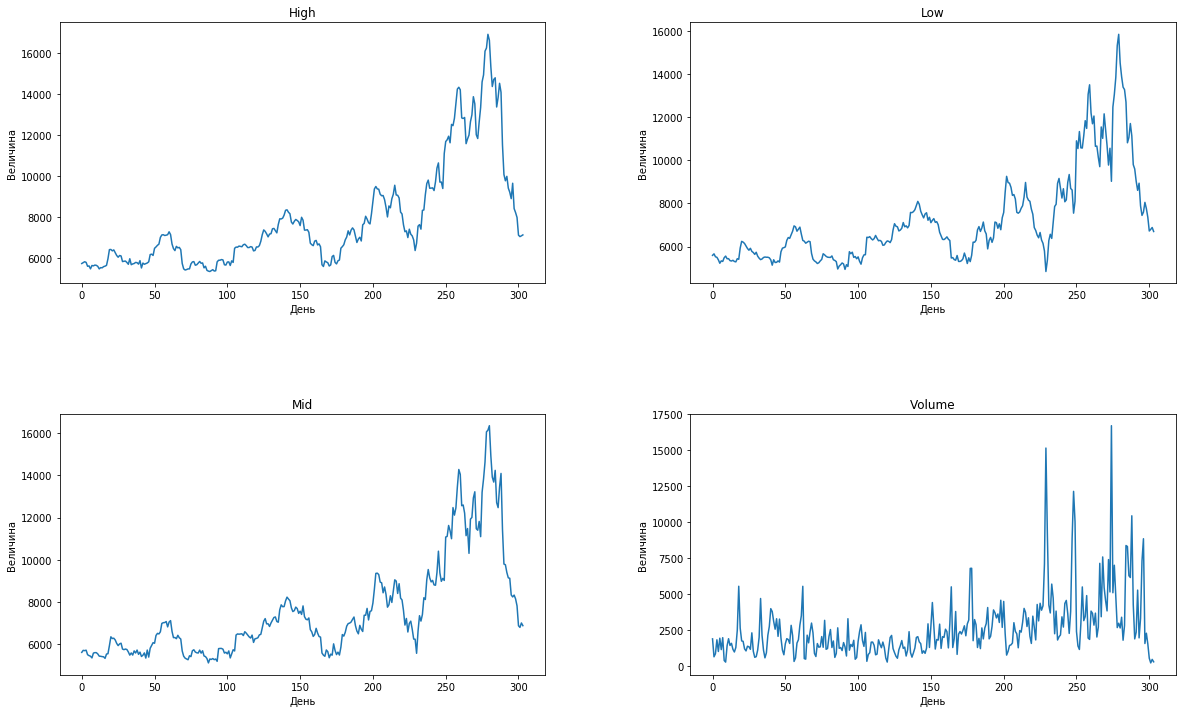

In [98]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
a = ['High', 'Low', 'Mid', 'Volume']
i = 0

for row in ax:
    for col in row:
        col.plot(f[a[i]])
        col.set_title(a[i])
        col.set_xlabel('День')
        col.set_ylabel('Величина')
        i = i + 1

fig.subplots_adjust(hspace=0.5, wspace=0.3)
print('До нормализации:')
plt.show()

Сделаем нормализацию признаков по диапазону (нормализация а) и построим новые графики

После нормализации a:


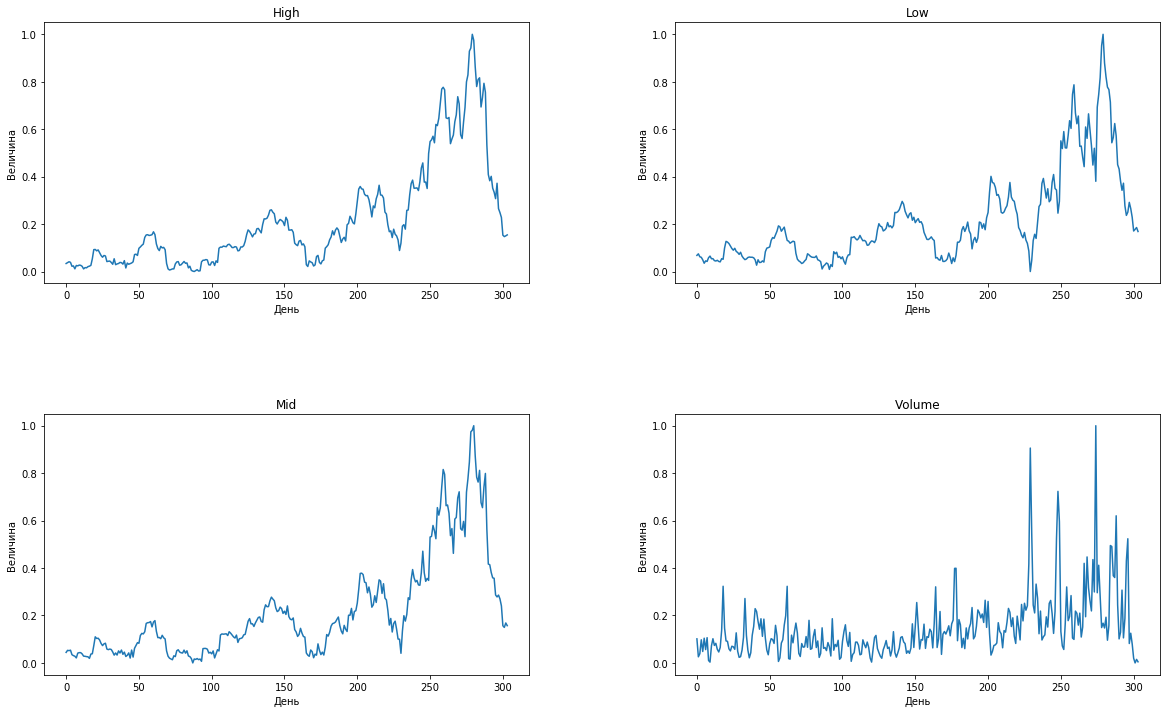

In [99]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
a = ['High', 'Low', 'Mid', 'Volume']
i = 0

f1 = f.copy()

for row in ax:
    for col in row:
        f1[a[i]] = (f[a[i]] - f[a[i]].min()) / (f[a[i]].max() - f[a[i]].min())
        col.plot(f1[a[i]])
        col.set_title(a[i])
        col.set_xlabel('День')
        col.set_ylabel('Величина')
        i = i + 1

fig.subplots_adjust(hspace=0.5, wspace=0.3)
print('После нормализации a:')
plt.show()

Сделаем нормализацию признаков по стандартному отклонению (нормализация b) и построим новые графики

После нормализации b:


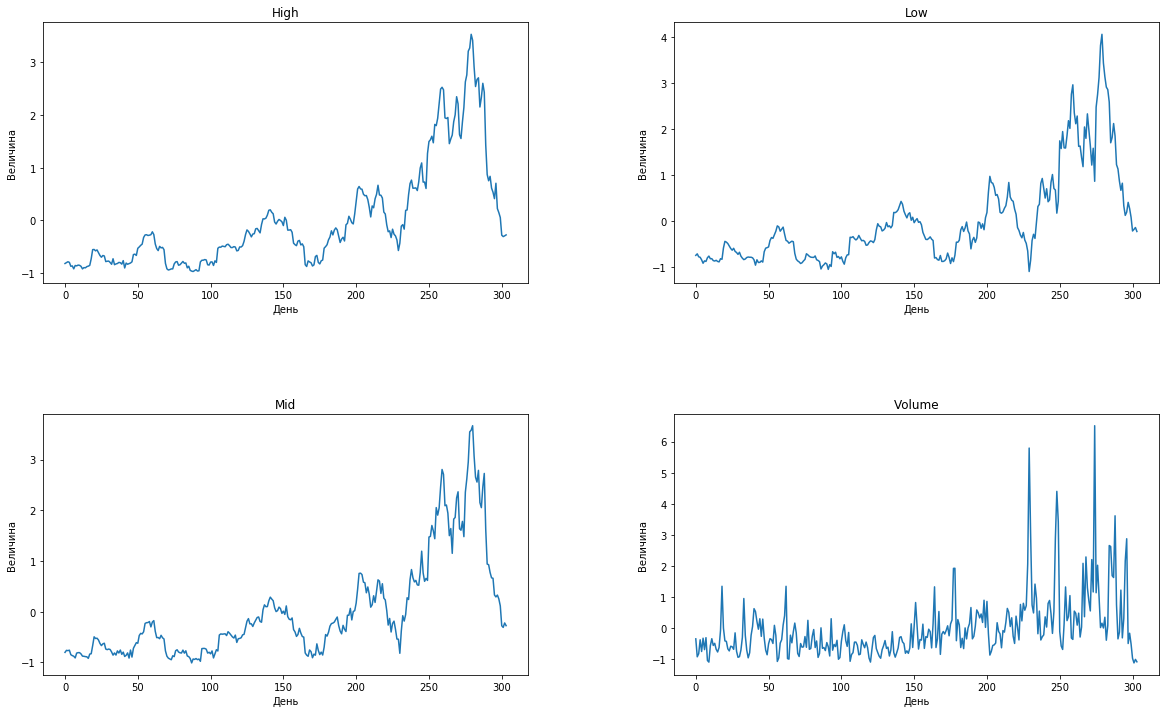

In [100]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
a = ['High', 'Low', 'Mid', 'Volume']
i = 0

f2 = f.copy()

for row in ax:
    for col in row:
        f2[a[i]] = (f[a[i]] - f[a[i]].mean()) / f[a[i]].std()
        col.plot(f2[a[i]])
        col.set_title(a[i])
        col.set_xlabel('День')
        col.set_ylabel('Величина')
        i = i + 1

fig.subplots_adjust(hspace=0.5, wspace=0.3)
print('После нормализации b:')
plt.show()

Как мы видим по графикам, нормализация просто масштабирует данные и проецирует их на меньший отрезок, при этом не меняя форму графика.

Теперь будем делать сам компонентный анализ. К счастью, сложные вычисления за нас в Python может сделать библиотека "PCA". 
Будем делать все шаги параллельно для двух нормализаций.

In [101]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

In [102]:
principalComponents = pca.fit_transform(f1)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['High', 'Low', 'Mid', 'Volume'])

principalComponents2 = pca.fit_transform(f2)
principalDf2 = pd.DataFrame(data = principalComponents2
             , columns = ['High', 'Low', 'Mid', 'Volume'])
principalDf2.head()

,High,Low,Mid,Volume
0,-1.408429,0.059937,-0.032216,0.029990
1,-1.523379,-0.505095,0.012823,-0.005428
2,-1.522669,-0.394440,0.048156,-0.036833
3,-1.404088,0.033564,0.030799,0.012731
4,-1.631514,-0.290934,0.031474,-0.017797


Вот так выглядит таблица с координатами для PCA после второй нормализации. Теперь построим красивые графики нашей визуализации

In [103]:
y = principalDf

y2 = principalDf2

У нас 4 параметра, а значит 4D пространство точек. Чтобы его отобразить для каждого случая нормализации мы нарисуем 6 графиков (по проекции на каждую из плоскостей) и после этого сравним результаты.

Вот построение 6 графиков для первой нормализации:

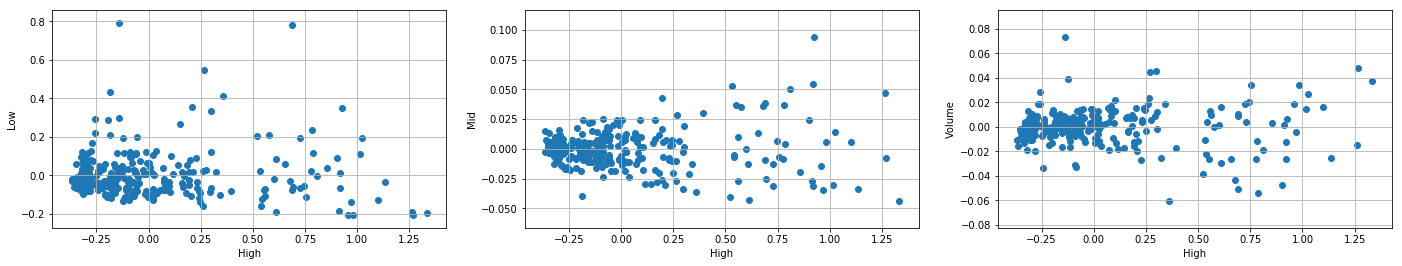

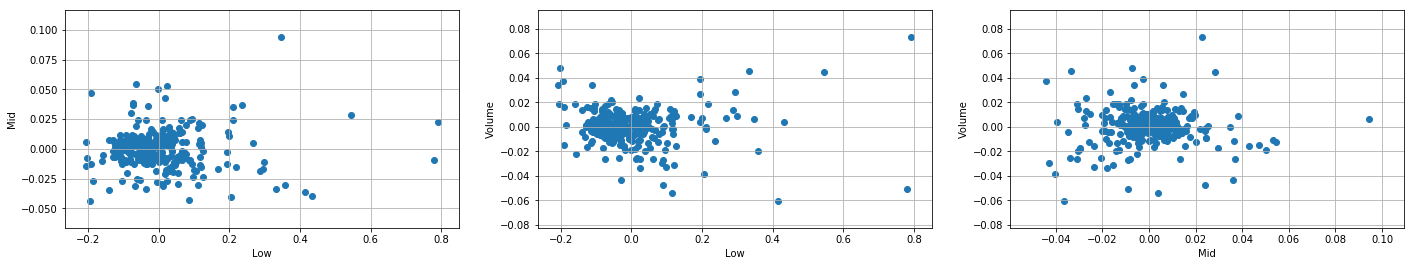

In [104]:
%matplotlib inline

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 4))
f2, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(24, 4))
p = 0
a = [y.High, y.Low, y.Mid, y.Volume]
b = ['High', 'Low', 'Mid', 'Volume']
ax = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in range(len(a)):
    for j in range(i + 1, len(a)):
        ax[p].scatter(a[i], a[j])
        ax[p].set_xlabel(b[i])
        ax[p].set_ylabel(b[j])
        ax[p].grid()
        p += 1

А вот для второй:

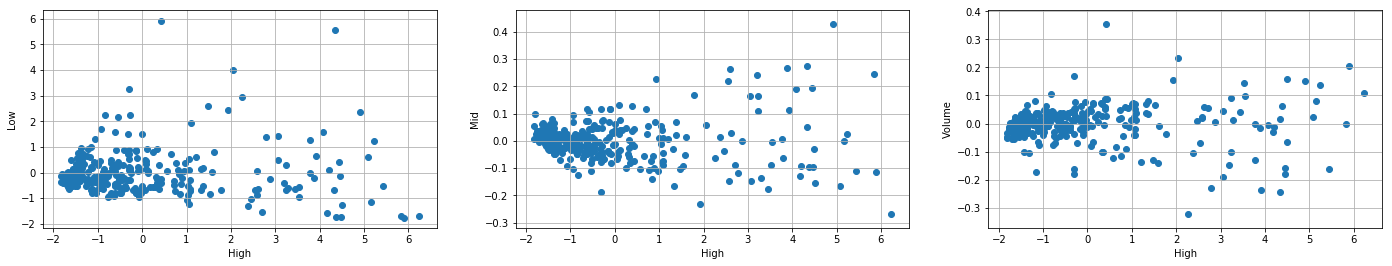

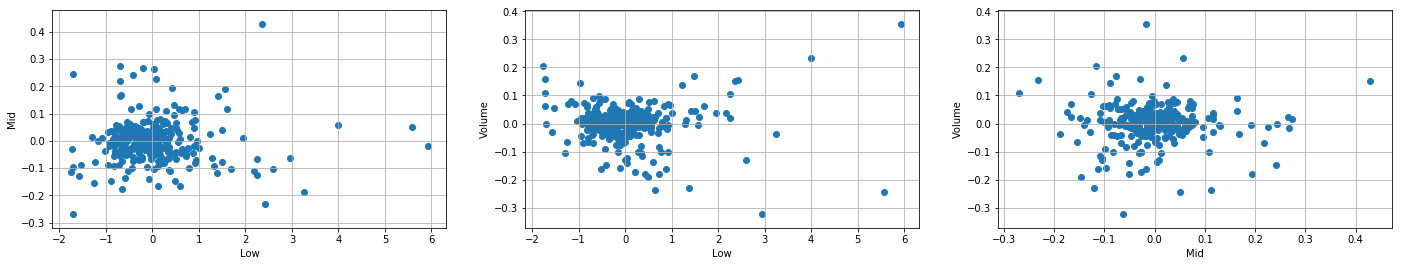

In [105]:
%matplotlib inline

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 4))
f2, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(24, 4))
p = 0
a = [y2.High, y2.Low, y2.Mid, y2.Volume]
b = ['High', 'Low', 'Mid', 'Volume']
ax = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in range(len(a)):
    for j in range(i + 1, len(a)):
        ax[p].scatter(a[i], a[j])
        ax[p].set_xlabel(b[i])
        ax[p].set_ylabel(b[j])
        ax[p].grid()
        p += 1

Итого, по разбросу точек PCA после двух нормализаций получились примерно одинаковые результаты: похожие центры концентрации и "форма" на всех графиках (на проекциях на все плоскости), но некоторые отдельные точки разбросаны по-разному. После первой нормализации признаки были спроецированы на отрезок от 0 до 1, а после второй от -1 до 6 (примерно), поэтому и на гарфиках PCA первая нормализация на меньшей площади, чем вторая. Ну и тут сложно сказать, какая нормализация лучше, потому что результат получился одинаковый с точностью до масштаба. Это значит, что при наших входных данных не так важно, какую нормализацию использовать.

<a id='6'></a>

# Линейная регрессия

Линейная регрессия - используемая в статистике регрессионная модель зависимости одной (объясняемой, зависимой) переменной y от другой или нескольких других переменных (факторов, регрессоров, независимых переменных) x  с линейной функцией зависимости. В нашем случае мы будем изучать зависимость известных нам данных друг от друга. И по ним предсказывать, насколько наша функция зависимости близка к линейной.

In [106]:
y = df.copy()
ych = y.copy()

В задании сказано найти данные, которые более-менее линейно зависят друг от друга. Для этого построим все графики и посмотрим зависимость. Можно заметить, что у многих из них зависимость практически линейная, однако не очень интересно анализировать те данные, что напрямую связаны (как максимальное и последнее значение например).

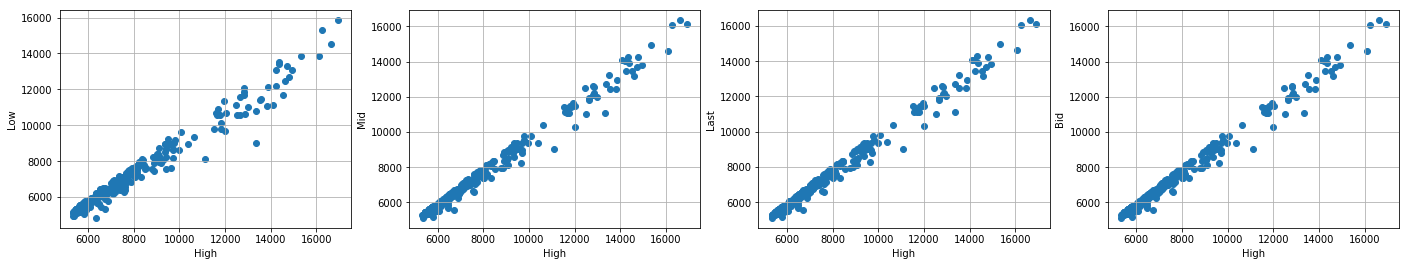

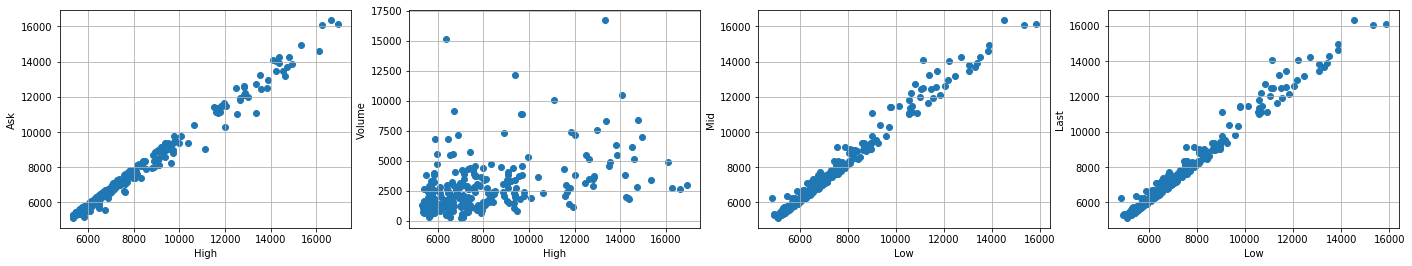

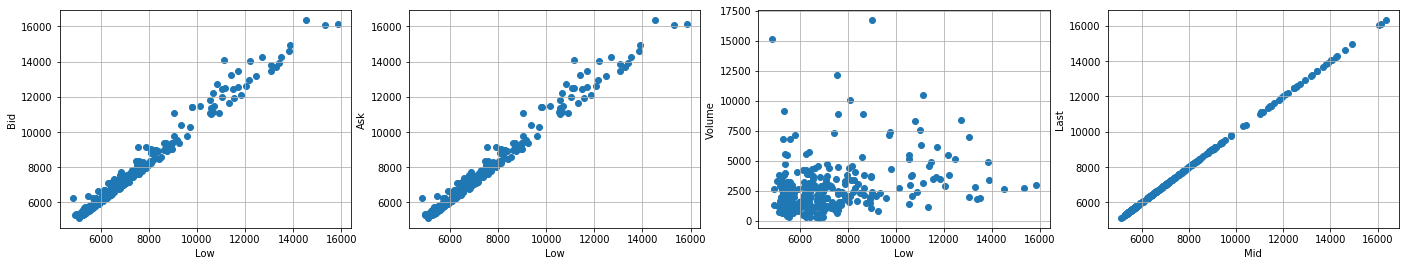

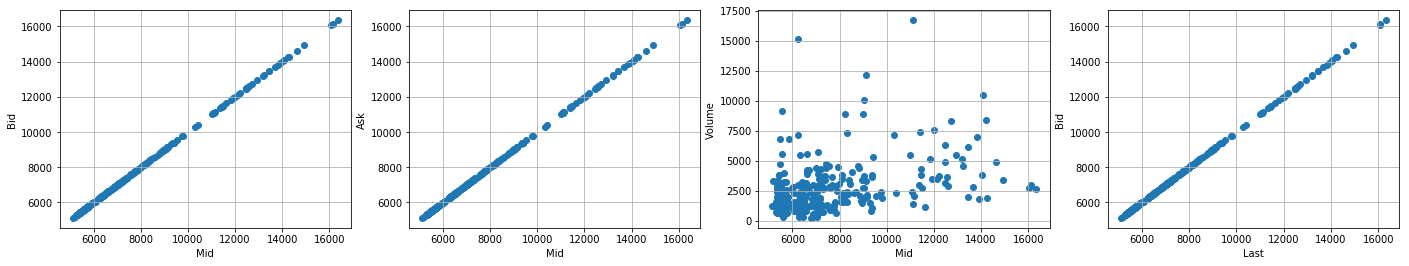

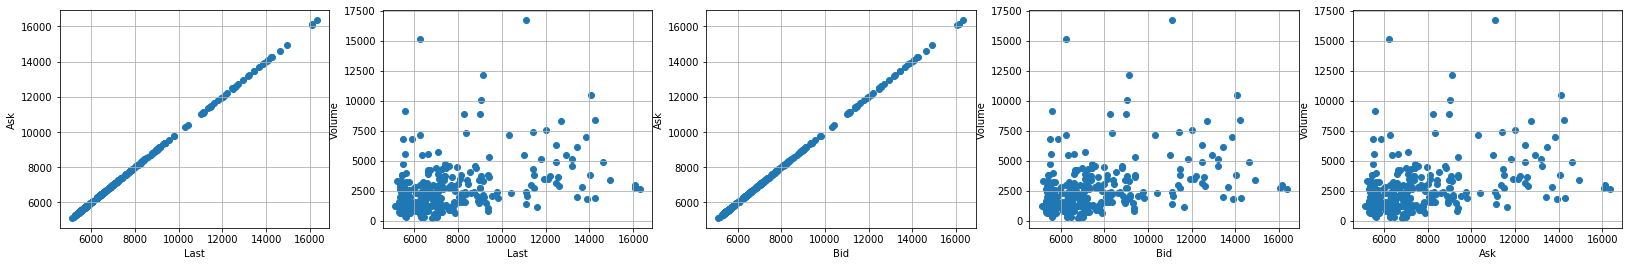

In [107]:
%matplotlib inline

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
f2, (ax5, ax6, ax7, ax8) = plt.subplots(1, 4, figsize=(24, 4))
f3, (ax9, ax10, ax11, ax12) = plt.subplots(1, 4, figsize=(24, 4))
f4, (ax13, ax14, ax15, ax16) = plt.subplots(1, 4, figsize=(24, 4))
f5, (ax17, ax18, ax19, ax20, ax21) = plt.subplots(1, 5, figsize=(28, 4))

p = 0
a = [y.High, y.Low, y.Mid, y.Last, y.Bid, y.Ask, y.Volume]
b = ['High', 'Low', 'Mid', 'Last', 'Bid', 'Ask', 'Volume']
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, 
      ax13, ax14, ax15, ax16, ax17, ax18,ax19, ax20, ax21]
for i in range(len(a)):
    for j in range(i + 1, len(a)):
        ax[p].scatter(a[i], a[j])
        ax[p].set_xlabel(b[i])
        ax[p].set_ylabel(b[j])
        ax[p].grid()
        p += 1

Поэтому возьмем зависимость спроса от предложения и построим отдельный для них график.

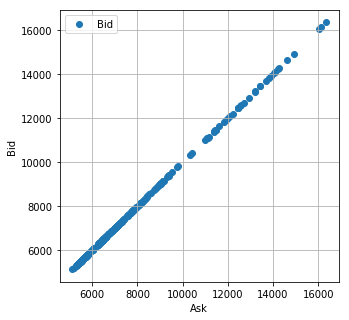

In [108]:
f, (ax) = plt.subplots(figsize=(5, 5))
ax.scatter(y.Ask, y.Bid)
ax.set_xlabel("Ask")
ax.set_ylabel("Bid")
ax.grid()
ax.legend()
plt.show()

In [109]:
lr = LinearRegression()

Чтобы сделать зависимость одного признака от другого, удалим из таблицы все признаки, кроме первого (предложение) и обучим линейную регрессию (на спросе).

In [110]:
minus = ych.drop('High', 1)
minus = minus.drop('Low', 1)
minus = minus.drop('Volume', 1)
minus = minus.drop('Last', 1)
minus = minus.drop('Date', 1)
minus = minus.drop('Ask', 1)
minus = minus.drop('Mid', 1)

In [111]:
x_train = minus
y_train = y.Ask

In [112]:
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Slope - коэффициент а для нашей прямой ax + b. В данном случае он получился практически равен единице, что говорит о том, что наша зависимость почти что линейная.

In [113]:
lr.coef_ #slope

array([1.00070416])

Теперь посчитаем коэффициент корреляции и детерминации. Рассчитаем их по формуле.

In [114]:
xx = []
for i in x_train.Bid:
    xx.append(i)
xx = np.array(xx)
yy = np.array(y_train)

In [115]:
xx2 = xx * xx
yy2 = yy * yy

In [116]:
up = np.sum(xx * yy)

In [117]:
down = (np.sum(xx2) * np.sum(yy2))**(0.5)

In [118]:
corr = up / down #коээфициент корреляции

In [119]:
deter = corr * corr
print("Коэффициент корреляции: ", corr, '\nКоэффициент детерминации: ', deter)

Коэффициент корреляции:  0.9999999394806677 
Коэффициент детерминации:  0.999999878961339


Сильно приближенный к единице коэффициент детерминации нам говорит, что функции очень скоррелированны, то есть здесь наблюдается сильная функциональная зависимость признаков, причем практически линейная. Теперь построим предсказания для 3х значений из нашей выборки и сравним их с реальным результатом.

In [120]:
predict = lr.predict(x_train)

In [121]:
print('Prediction: ', predict[0], '\nTrue value: ', y_train[0])
print('Prediction: ', predict[1], '\nTrue value: ', y_train[1])
print('Prediction: ', predict[2], '\nTrue value: ', y_train[2])

Prediction:  5621.291392428392 
True value:  5621.4
Prediction:  5716.558428619303 
True value:  5716.5
Prediction:  5703.64934493377 
True value:  5703.7


Можно заметить, что предсказания очень точные. Это должно нам показать маленькую ошибку.

In [122]:
print("Ошибка предсказания: ", mean_absolute_error(y_train, predict))

Ошибка предсказания:  1.3029307508849055


Как и было замечено раньше, ошибка получилась маленькой (почти незначительной), а значит, регрессия очень хорошо обучилась. Это нам в очередной раз доказывает, что связь между признаками была практически линейная. А значит, признак 'Bid' (предложение) очень сильно зависим от признака 'Ask' (спрос).

Теперь посмотрим на ошибку и на коэффициент детерминации. Они говорят нам об одних и тех же результатах, значит нет никакого противоречия в наших рассуждениях. Можем также сделать вывод, что большой коэффициент детерминации пораждает следствие, что ошибка предсказания будет небольшой.

Доказывая наше предположение, для примера рассмотрим другие признаки, график которых был далек от линейного. Рассмотрим его ошибку и коэффициент детерминации.

In [123]:
second = y.copy()

In [124]:
minus1 = second.drop('High', 1)
minus1 = minus1.drop('Low', 1)
minus1 = minus1.drop('Bid', 1)
minus1 = minus1.drop('Last', 1)
minus1 = minus1.drop('Date', 1)
minus1 = minus1.drop('Ask', 1)
minus1 = minus1.drop('Mid', 1)

In [125]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(minus1, y.Ask, train_size=0.8, random_state=42)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [126]:
lr.fit(x_train1, y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [127]:
xx1 = []
for i in x_train1.Volume:
    xx1.append(i)
xx1 = np.array(xx1)
yy1 = np.array(y_train1)

xx21 = xx1 * xx1
yy21 = yy1 * yy1

corr1 = np.sum(xx1 * yy1) / ((np.sum(xx21) * np.sum(yy21))**(0.5))
deter1 = corr1 * corr1

In [128]:
print("Коэффициент детерминации: ", deter1)

Коэффициент детерминации:  0.674916232106979


In [129]:
print("Ошибка предсказания: ", mean_absolute_error(y_test1, lr.predict(x_test1)))

Ошибка предсказания:  1871.1805388010523


На данном примере коэффициент детерминации получился совсем небольшим, а следствием из этого стала очень значительная ошибка. Значит, наши выводы насчет ошибки и детерминации были верны.

<a id='7'></a>

# Характеристика аккуратности, точности, полноты

С помощью построения таблиц сопряжённости и вычисления характеристик аккуратности, точности и полноты можно наглядно увидеть, насколько связаны параметры в данных и подробнее проанализировать, с чем это связано, и в каких случаях эта связь имеет большее значение и в какую сторону.

In [130]:
f = df.copy()
f.head()

,Date,High,Low,Mid,Last,Bid,Ask,Volume
0,2018-09-24,5725.000000,5590.700000,5621.30,5621.251288,5621.2,5621.4,1906.769859
1,2018-09-23,5765.500000,5660.500000,5716.45,5717.479110,5716.4,5716.5,661.228552
2,2018-09-22,5811.700000,5524.626745,5703.60,5701.700000,5703.5,5703.7,877.826894
3,2018-09-21,5779.800000,5500.700000,5724.70,5724.600000,5724.6,5724.8,1842.455638
4,2018-09-20,5590.000011,5383.100000,5511.90,5511.900000,5511.8,5512.0,1030.104288


Для дальнейших исследований выберем параметры High, Mid и Volume. 
Нам нужно сделать из количественного признака бинарный. Для этого мы построим по каждому признаку гистограмму. Найдём там значение признака такое, что его столбец на гистограмме меньше соседних (эта граница должна примерно визуально делить на две половины), и разделим по нему значения признака на две части (меньше и больше этой границы). Проделаем это для выбранных признаков.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


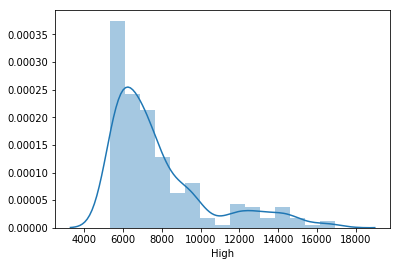

In [131]:
sns.distplot(f['High'])

In [132]:
f['binHigh'] = f['High']
for i in range(len(f)):
    if (f.loc[i, 'binHigh'] < 9000):
        f.loc[i, 'binHigh'] = 1
    else:
        f.loc[i, 'binHigh'] = 0
f.head()

,Date,High,Low,Mid,Last,Bid,Ask,Volume,binHigh
0,2018-09-24,5725.000000,5590.700000,5621.30,5621.251288,5621.2,5621.4,1906.769859,1.0
1,2018-09-23,5765.500000,5660.500000,5716.45,5717.479110,5716.4,5716.5,661.228552,1.0
2,2018-09-22,5811.700000,5524.626745,5703.60,5701.700000,5703.5,5703.7,877.826894,1.0
3,2018-09-21,5779.800000,5500.700000,5724.70,5724.600000,5724.6,5724.8,1842.455638,1.0
4,2018-09-20,5590.000011,5383.100000,5511.90,5511.900000,5511.8,5512.0,1030.104288,1.0


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


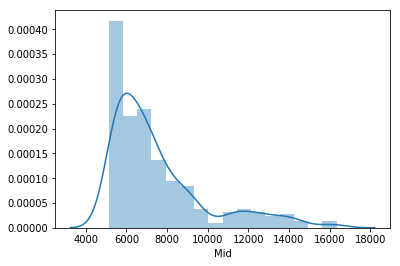

In [133]:
sns.distplot(f['Mid'])

In [134]:
f['binMid'] = f['Mid']
for i in range(len(f)):
    if (f.loc[i, 'binMid'] < 10000):
        f.loc[i, 'binMid'] = 1
    else:
        f.loc[i, 'binMid'] = 0
f.head()

,Date,High,Low,Mid,Last,Bid,Ask,Volume,binHigh,binMid
0,2018-09-24,5725.000000,5590.700000,5621.30,5621.251288,5621.2,5621.4,1906.769859,1.0,1.0
1,2018-09-23,5765.500000,5660.500000,5716.45,5717.479110,5716.4,5716.5,661.228552,1.0,1.0
2,2018-09-22,5811.700000,5524.626745,5703.60,5701.700000,5703.5,5703.7,877.826894,1.0,1.0
3,2018-09-21,5779.800000,5500.700000,5724.70,5724.600000,5724.6,5724.8,1842.455638,1.0,1.0
4,2018-09-20,5590.000011,5383.100000,5511.90,5511.900000,5511.8,5512.0,1030.104288,1.0,1.0


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


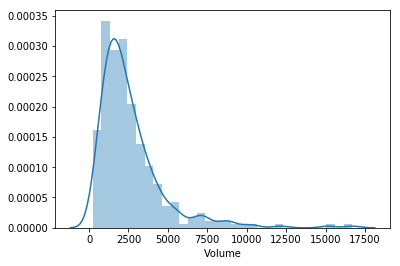

In [135]:
sns.distplot(f['Volume'])

In [136]:
f['binVolume'] = f['Volume']
for i in range(len(f)):
    if (f.loc[i, 'binVolume'] < 5000):
        f.loc[i, 'binVolume'] = 1
    else:
        f.loc[i, 'binVolume'] = 0
f.head()

,Date,High,Low,Mid,Last,Bid,Ask,Volume,binHigh,binMid,binVolume
0,2018-09-24,5725.000000,5590.700000,5621.30,5621.251288,5621.2,5621.4,1906.769859,1.0,1.0,1.0
1,2018-09-23,5765.500000,5660.500000,5716.45,5717.479110,5716.4,5716.5,661.228552,1.0,1.0,1.0
2,2018-09-22,5811.700000,5524.626745,5703.60,5701.700000,5703.5,5703.7,877.826894,1.0,1.0,1.0
3,2018-09-21,5779.800000,5500.700000,5724.70,5724.600000,5724.6,5724.8,1842.455638,1.0,1.0,1.0
4,2018-09-20,5590.000011,5383.100000,5511.90,5511.900000,5511.8,5512.0,1030.104288,1.0,1.0,1.0


Таким образом каждый признак мы разделили по значениям: маленькие цены (в High и Mid) и объёмы продаж (Volume) мы обозначили единицей, а большие нулём.

Мы получили три новых бинарных признака binHigh, binMid и binVolume. Объявим последний выходным, и для каждого из двух первых входных признаков построим таблицу сопряжённости с выходным и будем считать нужные характеристики. Начнём с binHigh.

In [137]:
a = np.zeros(4)
for i in range(len(f['binHigh'])):
    if (f['binHigh'][i] == 1):
        if (f['binVolume'][i] == 1):
            a[0] += 1
        else:
            a[1] +=1
    else:
        if (f['binVolume'][i] == 1):
            a[2] += 1
        else:
            a[3] +=1

df = pd.DataFrame(columns = ['Выход = 1', 'Выход = 0'])

df.loc['Вход = 1']= [a[0], a[1]]
df.loc['Вход = 0']= [a[2], a[3]]
df

,Выход = 1,Выход = 0
Вход = 1,223.0,10.0
Вход = 0,52.0,19.0


Теперь посчитаем характеристики аккуратности, точности и полноты

In [138]:
print('Accuracy ', 100 * (a[0] + a[3]) / (a[0] + a[1] + a[2] + a[3]))
print('Precision ', 100 * a[0] / (a[0] + a[1]))
print('Recall ', 100 * a[0] / (a[0] + a[2]))

Accuracy  79.60526315789474
Precision  95.70815450643777
Recall  81.0909090909091


Проделаем тоже самое для binMid

In [139]:
a = np.zeros(4)
for i in range(len(f['binMid'])):
    if (f['binMid'][i] == 1):
        if (f['binVolume'][i] == 1):
            a[0] += 1
        else:
            a[1] +=1
    else:
        if (f['binVolume'][i] == 1):
            a[2] += 1
        else:
            a[3] +=1

df = pd.DataFrame(columns = ['Выход = 1', 'Выход = 0'])

df.loc['Вход = 1']= [a[0], a[1]]
df.loc['Вход = 0']= [a[2], a[3]]
df

,Выход = 1,Выход = 0
Вход = 1,248.0,15.0
Вход = 0,27.0,14.0


In [140]:
print('Accuracy ', 100 * (a[0] + a[3]) / (a[0] + a[1] + a[2] + a[3]))
print('Precision ', 100 * a[0] / (a[0] + a[1]))
print('Recall ', 100 * a[0] / (a[0] + a[2]))

Accuracy  86.1842105263158
Precision  94.29657794676807
Recall  90.18181818181819


В первом случае аккуратность получилась 79.6%, во втором выше - 86.2%. Это связано с тем, что в целом объём продаж валюты (Volume) связан и с максимальной ценой (High), и с средней (Mid). Причём средняя цена лучше показывает объём, но оба эти показателя не полность отражают продажи, потому что на них также влияют и другие факторы, помимо цен. То же самое демонстрируют показатели точности и полноты. 

Точность в обоих случаях получилась довольно высокая - 95.7% и 94.3% соответственно. Это связано с тем, что из высокой цены почти всегда следует высокий объём продаж.

А вот полнота в обоих случаях ниже - 81% и 90.2%. Это связано с тем, что в некоторые дни и при невысокой цене были высокие продажи из-за других факторов.

<a id='8'></a>

# Заключение

Нашей группой было проведено исследование курса самой популярной криптовалюты - биткоина. В своей работе мы искали зависимости в данных с помощью следующих алгоритмов:
- **Метод K-средних**

В наших данных практически все параметры сильно скоррелированы со средним курсом биткоина, поэтому кластеры представляли из себя ценовые сегменты, что никак не говорит о перспективе и дальнейших изменениях курса.

- **Сравнений средних**

В продолжение кластеризации был разобран метод сравнения средних. С помощью бутстрапа генерировались выборки из датасета и считались средние значения для каждой из выборок. Метод бутстрап помогает уменьшить разброс в данных, что очень пригождается в случае с сильно колеблющемся биткоином.

- **Таблица сопряжённости**

Данный метод помогает исследовать зависимости данных от какого-либо конкретного параметра. В нашем случае, пользуясь таблицами сопряженности и измерением хи-квадратом пирсона, мы можем с большой вероятностью предсказать изменение курса биткоина в зависмости от других факторов. Безусловно, полезно иметь с большой вероятностью правдивое предсказание столь известной криптовалюты.

- **Метод главных компонент**

PCA позволяет "уменьшать" данные и отобразить их визуально для того, чтобы далее удобнее было отслеживать связи параметров. Мы использовали этот метод после разных вариантов нормализации данных. Но в случае с исследумыми данными о курсе биткоина неважно, как нормализовать данные, поэтому графики показали почти одинаковые результаты.

- **Линейная регрессия**

Мы рассмотрели зависимости в наших данных и обнаружили, что среди них есть практически линейные. С помощью этого метода и зная один из параметров (который мы исследовали) можно справедливо предсказать другой параметр с очень малой ошибкой. Опять же очевидно, что курс в течение дня редко сильно колеблется, поэтому параметры `High`, `Low`, `Last`, `Mid`, `Bid`, `Asc` практически равны в каждоый из дней, поэтому точность линейной регрессии высока.

- **Характеристика аккуратности, точности, полноты**

Данный метод отражает, насколько зависимы параметры в наших данных, а так же позволяет сделать выводы, за счёт чего именно складывается такая зависимость. Так мы посчитали, что объёмы цен и продаж валюты скореллированы, причем аккуратность, точность и полнота помогают проследить, в каких именно случаях наши предсказания будут работать точно, а в каких дадут ошибку. 

Все вышеперечисленные методы имеют свои особенности: как положительные, так и отрицательные. Для изучения исследуемого датасета, как нам кажется, больше подходит таблица сопряжённости, она лучше демонстрирует корреляции в данных и предсказывает дальнейшую судьбу криптовалюты.